In [1]:
# Validation of the steady-state simulation - Case 1: MLP with Optimal settings
## Optimal Settings are like below:
# 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
# 2. Cd scaling -> replaced as normalization for both Cl and Cd
# 3. Seperate the ML models into the two models, a model only for Cl and the other for Cd
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 + 3 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 1000 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [6]:
t_interval = 0.001
t_len = int((15-10) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [8]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = [cm_target[-4],] + cm_target[:-4] + cm_target[-3:]

In [9]:
cm_target

['NACA0018cm_blade1.csv',
 'case1cm_blade1.csv',
 'case2cm_blade1.csv',
 'case4cm_blade1.csv',
 'case5cm_blade1.csv',
 'case7cm_blade1.csv',
 'case8cm_blade1.csv',
 'case13cm_blade1.csv',
 'case14cm_blade1.csv',
 'case15cm_blade1.csv',
 'case16cm_blade1.csv',
 'case17cm_blade1.csv',
 'case18cm_blade1.csv',
 'case19cm_blade1.csv',
 'case20cm_blade1.csv',
 'case21cm_blade1.csv']

In [10]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
#     hh = generate_h(n_beta, t_len, normalize)
#     bb = generate_beta(n_beta, t_len, normalize)
#     total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    #x = np.hstack((t, hh, bb, total_coords))
    #x = np.hstack((t, total_coords))
    x = t
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x: ", x.shape)
    print("Dimension - y: ", y.shape)
    
    return x, y, t, cm

In [11]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    for i, file in enumerate(cm_target):
        df = pd.DataFrame()
        
        data = pd.read_csv(file, header=None)
        df = pd.concat([df, data], axis=0)
        
        time = df.iloc[:,0].values
        cm = df.iloc[:,1].values
        
        time_beUsed = time[np.where(np.logical_and(time>=10, time<15))]
        cm_beUsed = cm[np.where(np.logical_and(time>=10, time<15))]
        
        # Handle the time that is duplicated because of digits
        # Also, outliers are regulated at the second conditional statement.
        time_beUsed = handler_time(time_beUsed)
        cm_beUsed = handler_cm(cm_beUsed)
        
        linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                           bounds_error=False,kind='quadratic',
                                           fill_value='extrapolate')
        time_interp = np.arange(10, 15, t_interval).reshape((-1,1))
        cm_interp=linear_func(time_interp).reshape((-1,1))
        
        cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and Cm: ", input_time_cm.shape)
    return input_time_cm

In [12]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [13]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>10:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [14]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

    beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [15]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [16]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    
    baseline_coord_high = data.iloc[0,:]
    baseline_coord_low = data.iloc[1,:]
    baseline_coord = np.hstack((np.flip(baseline_coord_high), baseline_coord_low)).reshape((1,-1))
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [17]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j in range(n_beta):
            betaValue = beta[j]

            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords2 = np.zeros((n_cases, 10))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [18]:
# Generating x, y and cm (for denormalizing)
x, y, t, cm = genereate_input_output(cm_target[:2], n_beta, t_len, normalize=True)

Dimension - time and Cm:  (10000, 2)
Dimension - x:  (10000, 1)
Dimension - y:  (10000, 1)


In [19]:
x -=10

In [20]:
def dataset_split(x, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_all, x_test, y_all, y_test, cm_all, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_train, x_val, y_train, y_val, cm_train, cm_val = train_test_split(x_all, y_all, cm_all, test_size=val_rate/(1-test_rate),
                                                                            random_state=kwargs.get('random_state'))
        return x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_train, x_test, y_train, y_test, cm_train, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_train, x_test, y_train, y_test, cm_train, cm_test

In [21]:
x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x, y, cm,
                                                                                          test_rate, val_rate=val_rate,
                                                                                          validation=True, random_state=50)

In [22]:
def make_mlp_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_data = tf.keras.Input(shape=1)

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                #kernel_initializer='he_uniform',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(input_data)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     #kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       #kernel_initializer='he_uniform',
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model(input_data, output_data)
    
    return model

In [23]:
model = make_mlp_model(num_layer=n_layers)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 fc1 (Dense)                 (None, 256)               512       
                                                                 
 fc2 (Dense)                 (None, 256)               65792     
                                                                 
 fc3 (Dense)                 (None, 256)               65792     
                                                                 
 fc4 (Dense)                 (None, 256)               65792     
                                                                 
 fc5 (Dense)                 (None, 256)               65792     
                                                                 
 outputLayer (Dense)         (None, 1)                 257   

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [25]:
model_directory = "D:\\TrainedModels\\20221227_01Flaps_randomState50"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [26]:
ckpt_name = model_directory + "20221227unsteadyPrediction_MLP_01Flaps_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_layers)+"layers_"+ str(n_units) +"units_randomState50_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=500, min_delta=1e-07,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, factor=0.5,
                                          min_delta = 1e-8, min_lr=1e-06, verbose=1)

In [27]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [28]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=[x_val, y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
1/6 [====>.........................] - ETA: 6s - loss: 0.2728 - rmse: 0.5222
Epoch 1: val_loss improved from inf to 0.15901, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 2s 57ms/step - loss: 0.2286 - rmse: 0.4780 - val_loss: 0.1590 - val_rmse: 0.3986 - lr: 1.0000e-04
Epoch 2/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.1662 - rmse: 0.4076
Epoch 2: val_loss improved from 0.15901 to 0.10381, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 20ms/step - loss: 0.1373 - rmse: 0.3704 - val_loss: 0.1038 - val_rmse: 0.3220 - lr: 1.0000e-04
Epoch 3/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.1106 - rmse: 0.3324
Epoch 3: val_loss improved 

6/6 [==============================] - 0s 19ms/step - loss: 0.0654 - rmse: 0.2556 - val_loss: 0.0622 - val_rmse: 0.2492 - lr: 1.0000e-04
Epoch 21/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0631 - rmse: 0.2509
Epoch 21: val_loss improved from 0.06222 to 0.06209, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 19ms/step - loss: 0.0641 - rmse: 0.2529 - val_loss: 0.0621 - val_rmse: 0.2490 - lr: 1.0000e-04
Epoch 22/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0616 - rmse: 0.2479
Epoch 22: val_loss did not improve from 0.06209
6/6 [==============================] - 0s 10ms/step - loss: 0.0648 - rmse: 0.2544 - val_loss: 0.0625 - val_rmse: 0.2499 - lr: 1.0000e-04
Epoch 23/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0634 - rmse: 0.2516
Epoch 23: val_loss improved from 0.06209 to 0.061

Epoch 42/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0586 - rmse: 0.2419
Epoch 42: val_loss did not improve from 0.05950
6/6 [==============================] - 0s 12ms/step - loss: 0.0611 - rmse: 0.2470 - val_loss: 0.0600 - val_rmse: 0.2446 - lr: 1.0000e-04
Epoch 43/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0608 - rmse: 0.2464
Epoch 43: val_loss improved from 0.05950 to 0.05932, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 29ms/step - loss: 0.0624 - rmse: 0.2496 - val_loss: 0.0593 - val_rmse: 0.2434 - lr: 1.0000e-04
Epoch 44/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0577 - rmse: 0.2400
Epoch 44: val_loss improved from 0.05932 to 0.05923, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256unit

1/6 [====>.........................] - ETA: 0s - loss: 0.0613 - rmse: 0.2473
Epoch 63: val_loss improved from 0.05747 to 0.05713, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 29ms/step - loss: 0.0591 - rmse: 0.2429 - val_loss: 0.0571 - val_rmse: 0.2388 - lr: 1.0000e-04
Epoch 64/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0556 - rmse: 0.2355
Epoch 64: val_loss did not improve from 0.05713
6/6 [==============================] - 0s 14ms/step - loss: 0.0586 - rmse: 0.2420 - val_loss: 0.0574 - val_rmse: 0.2395 - lr: 1.0000e-04
Epoch 65/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0626 - rmse: 0.2501
Epoch 65: val_loss improved from 0.05713 to 0.05709, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50

Epoch 85/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0565 - rmse: 0.2374
Epoch 85: val_loss improved from 0.05509 to 0.05493, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 22ms/step - loss: 0.0575 - rmse: 0.2396 - val_loss: 0.0549 - val_rmse: 0.2342 - lr: 1.0000e-04
Epoch 86/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0526 - rmse: 0.2291
Epoch 86: val_loss improved from 0.05493 to 0.05487, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 23ms/step - loss: 0.0572 - rmse: 0.2390 - val_loss: 0.0549 - val_rmse: 0.2340 - lr: 1.0000e-04
Epoch 87/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0547 - rmse: 0.2337
Epoch 87: val_loss

6/6 [==============================] - 0s 25ms/step - loss: 0.0558 - rmse: 0.2360 - val_loss: 0.0536 - val_rmse: 0.2313 - lr: 1.0000e-04
Epoch 107/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0514 - rmse: 0.2264
Epoch 107: val_loss improved from 0.05362 to 0.05357, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 26ms/step - loss: 0.0544 - rmse: 0.2331 - val_loss: 0.0536 - val_rmse: 0.2312 - lr: 1.0000e-04
Epoch 108/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0557 - rmse: 0.2358
Epoch 108: val_loss improved from 0.05357 to 0.05340, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 0.0552 - rmse: 0.2347 - val_loss: 0.0534 - val

6/6 [==============================] - 0s 13ms/step - loss: 0.0532 - rmse: 0.2304 - val_loss: 0.0532 - val_rmse: 0.2305 - lr: 1.0000e-04
Epoch 131/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0533 - rmse: 0.2307
Epoch 131: val_loss improved from 0.05291 to 0.05289, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 22ms/step - loss: 0.0557 - rmse: 0.2359 - val_loss: 0.0529 - val_rmse: 0.2298 - lr: 1.0000e-04
Epoch 132/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0509 - rmse: 0.2254
Epoch 132: val_loss did not improve from 0.05289
6/6 [==============================] - 0s 14ms/step - loss: 0.0529 - rmse: 0.2298 - val_loss: 0.0531 - val_rmse: 0.2302 - lr: 1.0000e-04
Epoch 133/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0523 - rmse: 0.2285
Epoch 133: val_loss did not improve from 0.0

6/6 [==============================] - 0s 24ms/step - loss: 0.0537 - rmse: 0.2316 - val_loss: 0.0526 - val_rmse: 0.2291 - lr: 1.0000e-04
Epoch 155/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0517 - rmse: 0.2272
Epoch 155: val_loss did not improve from 0.05256
6/6 [==============================] - 0s 13ms/step - loss: 0.0539 - rmse: 0.2321 - val_loss: 0.0526 - val_rmse: 0.2292 - lr: 1.0000e-04
Epoch 156/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0528 - rmse: 0.2295
Epoch 156: val_loss did not improve from 0.05256
6/6 [==============================] - 0s 13ms/step - loss: 0.0523 - rmse: 0.2284 - val_loss: 0.0526 - val_rmse: 0.2292 - lr: 1.0000e-04
Epoch 157/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0603 - rmse: 0.2453
Epoch 157: val_loss did not improve from 0.05256
6/6 [==============================] - 0s 14ms/step - loss: 0.0550 - rmse: 0.2344 - val_loss: 0.0528 - val_rmse: 0.2296 - lr: 1.0000e-04
Epoch 158/10000
1/6 [====>

Epoch 180/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0607 - rmse: 0.2462
Epoch 180: val_loss did not improve from 0.05221
6/6 [==============================] - 0s 14ms/step - loss: 0.0542 - rmse: 0.2327 - val_loss: 0.0525 - val_rmse: 0.2290 - lr: 1.0000e-04
Epoch 181/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0521 - rmse: 0.2281
Epoch 181: val_loss did not improve from 0.05221
6/6 [==============================] - 0s 13ms/step - loss: 0.0538 - rmse: 0.2318 - val_loss: 0.0529 - val_rmse: 0.2297 - lr: 1.0000e-04
Epoch 182/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0550 - rmse: 0.2344
Epoch 182: val_loss did not improve from 0.05221
6/6 [==============================] - 0s 14ms/step - loss: 0.0545 - rmse: 0.2333 - val_loss: 0.0536 - val_rmse: 0.2314 - lr: 1.0000e-04
Epoch 183/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0524 - rmse: 0.2287
Epoch 183: val_loss did not improve from 0.05221
6/6 [================

1/6 [====>.........................] - ETA: 0s - loss: 0.0561 - rmse: 0.2367
Epoch 205: val_loss did not improve from 0.05184
6/6 [==============================] - 0s 13ms/step - loss: 0.0542 - rmse: 0.2326 - val_loss: 0.0520 - val_rmse: 0.2278 - lr: 1.0000e-04
Epoch 206/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0485 - rmse: 0.2200
Epoch 206: val_loss did not improve from 0.05184
6/6 [==============================] - 0s 13ms/step - loss: 0.0520 - rmse: 0.2278 - val_loss: 0.0519 - val_rmse: 0.2275 - lr: 1.0000e-04
Epoch 207/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0545 - rmse: 0.2333
Epoch 207: val_loss did not improve from 0.05184
6/6 [==============================] - 0s 13ms/step - loss: 0.0538 - rmse: 0.2317 - val_loss: 0.0519 - val_rmse: 0.2277 - lr: 1.0000e-04
Epoch 208/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0544 - rmse: 0.2330
Epoch 208: val_loss improved from 0.05184 to 0.05179, saving model to D:\TrainedModels

6/6 [==============================] - 0s 23ms/step - loss: 0.0530 - rmse: 0.2300 - val_loss: 0.0514 - val_rmse: 0.2264 - lr: 1.0000e-04
Epoch 232/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0537 - rmse: 0.2316
Epoch 232: val_loss improved from 0.05137 to 0.05135, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 0.0524 - rmse: 0.2288 - val_loss: 0.0513 - val_rmse: 0.2264 - lr: 1.0000e-04
Epoch 233/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0545 - rmse: 0.2332
Epoch 233: val_loss did not improve from 0.05135
6/6 [==============================] - 0s 13ms/step - loss: 0.0521 - rmse: 0.2280 - val_loss: 0.0516 - val_rmse: 0.2269 - lr: 1.0000e-04
Epoch 234/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0532 - rmse: 0.2304
Epoch 234: val_loss improved from 0.05135 to

Epoch 257/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0504 - rmse: 0.2243
Epoch 257: val_loss did not improve from 0.05094
6/6 [==============================] - 0s 13ms/step - loss: 0.0545 - rmse: 0.2332 - val_loss: 0.0511 - val_rmse: 0.2258 - lr: 1.0000e-04
Epoch 258/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0537 - rmse: 0.2315
Epoch 258: val_loss did not improve from 0.05094
6/6 [==============================] - 0s 14ms/step - loss: 0.0526 - rmse: 0.2291 - val_loss: 0.0518 - val_rmse: 0.2274 - lr: 1.0000e-04
Epoch 259/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0510 - rmse: 0.2257
Epoch 259: val_loss improved from 0.05094 to 0.05092, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 0.0526 - rmse: 0.2292 - val_loss: 0.0509 - val_rmse: 0.2254 - lr: 1.0000

1/6 [====>.........................] - ETA: 0s - loss: 0.0545 - rmse: 0.2332
Epoch 282: val_loss did not improve from 0.05046
6/6 [==============================] - 0s 13ms/step - loss: 0.0525 - rmse: 0.2289 - val_loss: 0.0507 - val_rmse: 0.2249 - lr: 1.0000e-04
Epoch 283/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0531 - rmse: 0.2302
Epoch 283: val_loss did not improve from 0.05046
6/6 [==============================] - 0s 13ms/step - loss: 0.0526 - rmse: 0.2291 - val_loss: 0.0505 - val_rmse: 0.2246 - lr: 1.0000e-04
Epoch 284/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0534 - rmse: 0.2308
Epoch 284: val_loss did not improve from 0.05046
6/6 [==============================] - 0s 13ms/step - loss: 0.0509 - rmse: 0.2254 - val_loss: 0.0506 - val_rmse: 0.2247 - lr: 1.0000e-04
Epoch 285/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0522 - rmse: 0.2283
Epoch 285: val_loss did not improve from 0.05046
6/6 [==============================] 

Epoch 308/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0475 - rmse: 0.2178
Epoch 308: val_loss did not improve from 0.05011
6/6 [==============================] - 0s 13ms/step - loss: 0.0513 - rmse: 0.2264 - val_loss: 0.0504 - val_rmse: 0.2244 - lr: 1.0000e-04
Epoch 309/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0521 - rmse: 0.2281
Epoch 309: val_loss did not improve from 0.05011
6/6 [==============================] - 0s 13ms/step - loss: 0.0518 - rmse: 0.2274 - val_loss: 0.0504 - val_rmse: 0.2244 - lr: 1.0000e-04
Epoch 310/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0511 - rmse: 0.2259
Epoch 310: val_loss improved from 0.05011 to 0.05006, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 25ms/step - loss: 0.0524 - rmse: 0.2288 - val_loss: 0.0501 - val_rmse: 0.2236 - lr: 1.0000

6/6 [==============================] - 0s 13ms/step - loss: 0.0512 - rmse: 0.2261 - val_loss: 0.0499 - val_rmse: 0.2231 - lr: 1.0000e-04
Epoch 332/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0538 - rmse: 0.2319
Epoch 332: val_loss did not improve from 0.04963
6/6 [==============================] - 0s 13ms/step - loss: 0.0506 - rmse: 0.2249 - val_loss: 0.0498 - val_rmse: 0.2230 - lr: 1.0000e-04
Epoch 333/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0565 - rmse: 0.2374
Epoch 333: val_loss did not improve from 0.04963
6/6 [==============================] - 0s 13ms/step - loss: 0.0526 - rmse: 0.2293 - val_loss: 0.0496 - val_rmse: 0.2226 - lr: 1.0000e-04
Epoch 334/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0509 - rmse: 0.2255
Epoch 334: val_loss did not improve from 0.04963
6/6 [==============================] - 0s 13ms/step - loss: 0.0503 - rmse: 0.2241 - val_loss: 0.0496 - val_rmse: 0.2226 - lr: 1.0000e-04
Epoch 335/10000
1/6 [====>

1/6 [====>.........................] - ETA: 0s - loss: 0.0471 - rmse: 0.2168
Epoch 357: val_loss improved from 0.04903 to 0.04901, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 34ms/step - loss: 0.0508 - rmse: 0.2252 - val_loss: 0.0490 - val_rmse: 0.2212 - lr: 1.0000e-04
Epoch 358/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0446 - rmse: 0.2109
Epoch 358: val_loss did not improve from 0.04901
6/6 [==============================] - 0s 13ms/step - loss: 0.0505 - rmse: 0.2245 - val_loss: 0.0510 - val_rmse: 0.2256 - lr: 1.0000e-04
Epoch 359/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0510 - rmse: 0.2256
Epoch 359: val_loss did not improve from 0.04901
6/6 [==============================] - 0s 13ms/step - loss: 0.0507 - rmse: 0.2249 - val_loss: 0.0502 - val_rmse: 0.2239 - lr: 1.0000e-04
Epoch 360/1

Epoch 382/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0478 - rmse: 0.2184
Epoch 382: val_loss improved from 0.04842 to 0.04826, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 22ms/step - loss: 0.0489 - rmse: 0.2209 - val_loss: 0.0483 - val_rmse: 0.2195 - lr: 1.0000e-04
Epoch 383/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0489 - rmse: 0.2209
Epoch 383: val_loss did not improve from 0.04826
6/6 [==============================] - 0s 13ms/step - loss: 0.0504 - rmse: 0.2244 - val_loss: 0.0483 - val_rmse: 0.2196 - lr: 1.0000e-04
Epoch 384/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0489 - rmse: 0.2210
Epoch 384: val_loss improved from 0.04826 to 0.04813, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_2

6/6 [==============================] - 0s 13ms/step - loss: 0.0476 - rmse: 0.2179 - val_loss: 0.0478 - val_rmse: 0.2185 - lr: 1.0000e-04
Epoch 406/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0483 - rmse: 0.2196
Epoch 406: val_loss improved from 0.04751 to 0.04734, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 0.0487 - rmse: 0.2206 - val_loss: 0.0473 - val_rmse: 0.2174 - lr: 1.0000e-04
Epoch 407/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0504 - rmse: 0.2244
Epoch 407: val_loss did not improve from 0.04734
6/6 [==============================] - 0s 14ms/step - loss: 0.0485 - rmse: 0.2200 - val_loss: 0.0474 - val_rmse: 0.2176 - lr: 1.0000e-04
Epoch 408/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0500 - rmse: 0.2234
Epoch 408: val_loss improved from 0.04734 to

6/6 [==============================] - 0s 13ms/step - loss: 0.0466 - rmse: 0.2157 - val_loss: 0.0471 - val_rmse: 0.2168 - lr: 1.0000e-04
Epoch 430/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0502 - rmse: 0.2240
Epoch 430: val_loss did not improve from 0.04633
6/6 [==============================] - 0s 13ms/step - loss: 0.0489 - rmse: 0.2209 - val_loss: 0.0464 - val_rmse: 0.2152 - lr: 1.0000e-04
Epoch 431/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0463 - rmse: 0.2149
Epoch 431: val_loss improved from 0.04633 to 0.04604, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 22ms/step - loss: 0.0461 - rmse: 0.2146 - val_loss: 0.0460 - val_rmse: 0.2144 - lr: 1.0000e-04
Epoch 432/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0482 - rmse: 0.2193
Epoch 432: val_loss did not improve from 0.0

6/6 [==============================] - 0s 23ms/step - loss: 0.0456 - rmse: 0.2134 - val_loss: 0.0449 - val_rmse: 0.2118 - lr: 1.0000e-04
Epoch 454/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0473 - rmse: 0.2174
Epoch 454: val_loss improved from 0.04492 to 0.04476, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 26ms/step - loss: 0.0457 - rmse: 0.2135 - val_loss: 0.0448 - val_rmse: 0.2114 - lr: 1.0000e-04
Epoch 455/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0438 - rmse: 0.2092
Epoch 455: val_loss did not improve from 0.04476
6/6 [==============================] - 0s 13ms/step - loss: 0.0459 - rmse: 0.2141 - val_loss: 0.0448 - val_rmse: 0.2115 - lr: 1.0000e-04
Epoch 456/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0468 - rmse: 0.2161
Epoch 456: val_loss did not improve from 0.0

6/6 [==============================] - 0s 25ms/step - loss: 0.0451 - rmse: 0.2122 - val_loss: 0.0437 - val_rmse: 0.2088 - lr: 1.0000e-04
Epoch 479/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0400 - rmse: 0.1998
Epoch 479: val_loss did not improve from 0.04368
6/6 [==============================] - 0s 13ms/step - loss: 0.0446 - rmse: 0.2110 - val_loss: 0.0440 - val_rmse: 0.2096 - lr: 1.0000e-04
Epoch 480/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0428 - rmse: 0.2068
Epoch 480: val_loss did not improve from 0.04368
6/6 [==============================] - 0s 13ms/step - loss: 0.0431 - rmse: 0.2073 - val_loss: 0.0440 - val_rmse: 0.2095 - lr: 1.0000e-04
Epoch 481/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0470 - rmse: 0.2167
Epoch 481: val_loss improved from 0.04368 to 0.04363, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoin

Epoch 504/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0459 - rmse: 0.2140
Epoch 504: val_loss improved from 0.04274 to 0.04261, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 22ms/step - loss: 0.0437 - rmse: 0.2088 - val_loss: 0.0426 - val_rmse: 0.2062 - lr: 1.0000e-04
Epoch 505/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0394 - rmse: 0.1983
Epoch 505: val_loss did not improve from 0.04261
6/6 [==============================] - 0s 13ms/step - loss: 0.0429 - rmse: 0.2070 - val_loss: 0.0429 - val_rmse: 0.2068 - lr: 1.0000e-04
Epoch 506/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0468 - rmse: 0.2161
Epoch 506: val_loss did not improve from 0.04261
6/6 [==============================] - 0s 13ms/step - loss: 0.0441 - rmse: 0.2097 - val_loss: 0.0428 - val_rmse: 0.2066 - lr: 1.0000

Epoch 529/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0456 - rmse: 0.2135
Epoch 529: val_loss did not improve from 0.04166
6/6 [==============================] - 0s 13ms/step - loss: 0.0438 - rmse: 0.2092 - val_loss: 0.0419 - val_rmse: 0.2045 - lr: 1.0000e-04
Epoch 530/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0408 - rmse: 0.2018
Epoch 530: val_loss did not improve from 0.04166
6/6 [==============================] - 0s 14ms/step - loss: 0.0425 - rmse: 0.2059 - val_loss: 0.0418 - val_rmse: 0.2043 - lr: 1.0000e-04
Epoch 531/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0374 - rmse: 0.1931
Epoch 531: val_loss did not improve from 0.04166
6/6 [==============================] - 0s 13ms/step - loss: 0.0417 - rmse: 0.2039 - val_loss: 0.0419 - val_rmse: 0.2046 - lr: 1.0000e-04
Epoch 532/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0417 - rmse: 0.2040
Epoch 532: val_loss did not improve from 0.04166
6/6 [================

6/6 [==============================] - 0s 13ms/step - loss: 0.0428 - rmse: 0.2066 - val_loss: 0.0414 - val_rmse: 0.2033 - lr: 1.0000e-04
Epoch 556/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0381 - rmse: 0.1950
Epoch 556: val_loss did not improve from 0.04110
6/6 [==============================] - 0s 14ms/step - loss: 0.0417 - rmse: 0.2040 - val_loss: 0.0411 - val_rmse: 0.2026 - lr: 1.0000e-04
Epoch 557/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0418 - rmse: 0.2043
Epoch 557: val_loss improved from 0.04110 to 0.04107, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 25ms/step - loss: 0.0422 - rmse: 0.2051 - val_loss: 0.0411 - val_rmse: 0.2025 - lr: 1.0000e-04
Epoch 558/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0422 - rmse: 0.2053
Epoch 558: val_loss did not improve from 0.0

1/6 [====>.........................] - ETA: 0s - loss: 0.0424 - rmse: 0.2058
Epoch 581: val_loss improved from 0.04075 to 0.04074, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 27ms/step - loss: 0.0416 - rmse: 0.2038 - val_loss: 0.0407 - val_rmse: 0.2016 - lr: 1.0000e-04
Epoch 582/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0411 - rmse: 0.2025
Epoch 582: val_loss improved from 0.04074 to 0.04045, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 0.0414 - rmse: 0.2033 - val_loss: 0.0405 - val_rmse: 0.2009 - lr: 1.0000e-04
Epoch 583/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0404 - rmse: 0.2008
Epoch 583: val_loss did not i

Epoch 607/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0405 - rmse: 0.2011
Epoch 607: val_loss did not improve from 0.04028
6/6 [==============================] - 0s 14ms/step - loss: 0.0418 - rmse: 0.2042 - val_loss: 0.0409 - val_rmse: 0.2021 - lr: 1.0000e-04
Epoch 608/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0474 - rmse: 0.2175
Epoch 608: val_loss improved from 0.04028 to 0.04019, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 0.0420 - rmse: 0.2049 - val_loss: 0.0402 - val_rmse: 0.2003 - lr: 1.0000e-04
Epoch 609/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0402 - rmse: 0.2004
Epoch 609: val_loss did not improve from 0.04019
6/6 [==============================] - 0s 14ms/step - loss: 0.0412 - rmse: 0.2027 - val_loss: 0.0409 - val_rmse: 0.2020 - lr: 1.0000

Epoch 631/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0423 - rmse: 0.2056
Epoch 631: val_loss did not improve from 0.03962
6/6 [==============================] - 0s 14ms/step - loss: 0.0397 - rmse: 0.1992 - val_loss: 0.0399 - val_rmse: 0.1996 - lr: 1.0000e-04
Epoch 632/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0447 - rmse: 0.2113
Epoch 632: val_loss did not improve from 0.03962
6/6 [==============================] - 0s 14ms/step - loss: 0.0419 - rmse: 0.2046 - val_loss: 0.0398 - val_rmse: 0.1993 - lr: 1.0000e-04
Epoch 633/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0413 - rmse: 0.2030
Epoch 633: val_loss did not improve from 0.03962
6/6 [==============================] - 0s 14ms/step - loss: 0.0409 - rmse: 0.2020 - val_loss: 0.0410 - val_rmse: 0.2023 - lr: 1.0000e-04
Epoch 634/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0416 - rmse: 0.2038
Epoch 634: val_loss did not improve from 0.03962
6/6 [================

Epoch 659/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0387 - rmse: 0.1964
Epoch 659: val_loss improved from 0.03941 to 0.03941, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 34ms/step - loss: 0.0401 - rmse: 0.2000 - val_loss: 0.0394 - val_rmse: 0.1983 - lr: 1.0000e-04
Epoch 660/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0399 - rmse: 0.1997
Epoch 660: val_loss did not improve from 0.03941
6/6 [==============================] - 0s 13ms/step - loss: 0.0407 - rmse: 0.2015 - val_loss: 0.0400 - val_rmse: 0.1999 - lr: 1.0000e-04
Epoch 661/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0375 - rmse: 0.1935
Epoch 661: val_loss did not improve from 0.03941
6/6 [==============================] - 0s 14ms/step - loss: 0.0394 - rmse: 0.1984 - val_loss: 0.0395 - val_rmse: 0.1985 - lr: 1.0000

6/6 [==============================] - 0s 14ms/step - loss: 0.0390 - rmse: 0.1972 - val_loss: 0.0390 - val_rmse: 0.1974 - lr: 1.0000e-04
Epoch 686/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0413 - rmse: 0.2030
Epoch 686: val_loss did not improve from 0.03888
6/6 [==============================] - 0s 14ms/step - loss: 0.0396 - rmse: 0.1988 - val_loss: 0.0400 - val_rmse: 0.1998 - lr: 1.0000e-04
Epoch 687/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0403 - rmse: 0.2005
Epoch 687: val_loss improved from 0.03888 to 0.03869, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 29ms/step - loss: 0.0402 - rmse: 0.2004 - val_loss: 0.0387 - val_rmse: 0.1965 - lr: 1.0000e-04
Epoch 688/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0383 - rmse: 0.1956
Epoch 688: val_loss did not improve from 0.0

1/6 [====>.........................] - ETA: 0s - loss: 0.0389 - rmse: 0.1970
Epoch 713: val_loss improved from 0.03861 to 0.03851, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 0.0397 - rmse: 0.1991 - val_loss: 0.0385 - val_rmse: 0.1961 - lr: 1.0000e-04
Epoch 714/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0405 - rmse: 0.2011
Epoch 714: val_loss did not improve from 0.03851
6/6 [==============================] - 0s 13ms/step - loss: 0.0393 - rmse: 0.1981 - val_loss: 0.0386 - val_rmse: 0.1963 - lr: 1.0000e-04
Epoch 715/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0402 - rmse: 0.2003
Epoch 715: val_loss did not improve from 0.03851
6/6 [==============================] - 0s 13ms/step - loss: 0.0389 - rmse: 0.1971 - val_loss: 0.0390 - val_rmse: 0.1973 - lr: 1.0000e-04
Epoch 716/1

6/6 [==============================] - 0s 13ms/step - loss: 0.0382 - rmse: 0.1952 - val_loss: 0.0382 - val_rmse: 0.1952 - lr: 1.0000e-04
Epoch 740/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0371 - rmse: 0.1923
Epoch 740: val_loss did not improve from 0.03808
6/6 [==============================] - 0s 13ms/step - loss: 0.0397 - rmse: 0.1991 - val_loss: 0.0382 - val_rmse: 0.1952 - lr: 1.0000e-04
Epoch 741/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0408 - rmse: 0.2019
Epoch 741: val_loss improved from 0.03808 to 0.03790, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 25ms/step - loss: 0.0377 - rmse: 0.1940 - val_loss: 0.0379 - val_rmse: 0.1945 - lr: 1.0000e-04
Epoch 742/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0392 - rmse: 0.1979
Epoch 742: val_loss did not improve from 0.0

6/6 [==============================] - 0s 32ms/step - loss: 0.0370 - rmse: 0.1922 - val_loss: 0.0374 - val_rmse: 0.1933 - lr: 1.0000e-04
Epoch 766/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0400 - rmse: 0.1997
Epoch 766: val_loss did not improve from 0.03743
6/6 [==============================] - 0s 13ms/step - loss: 0.0373 - rmse: 0.1931 - val_loss: 0.0379 - val_rmse: 0.1946 - lr: 1.0000e-04
Epoch 767/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0395 - rmse: 0.1985
Epoch 767: val_loss did not improve from 0.03743
6/6 [==============================] - 0s 13ms/step - loss: 0.0398 - rmse: 0.1993 - val_loss: 0.0374 - val_rmse: 0.1933 - lr: 1.0000e-04
Epoch 768/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0394 - rmse: 0.1984
Epoch 768: val_loss did not improve from 0.03743
6/6 [==============================] - 0s 13ms/step - loss: 0.0376 - rmse: 0.1937 - val_loss: 0.0385 - val_rmse: 0.1960 - lr: 1.0000e-04
Epoch 769/10000
1/6 [====>

6/6 [==============================] - 0s 13ms/step - loss: 0.0370 - rmse: 0.1922 - val_loss: 0.0374 - val_rmse: 0.1932 - lr: 1.0000e-04
Epoch 793/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0412 - rmse: 0.2029
Epoch 793: val_loss did not improve from 0.03701
6/6 [==============================] - 0s 13ms/step - loss: 0.0383 - rmse: 0.1955 - val_loss: 0.0373 - val_rmse: 0.1930 - lr: 1.0000e-04
Epoch 794/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0377 - rmse: 0.1940
Epoch 794: val_loss did not improve from 0.03701
6/6 [==============================] - 0s 14ms/step - loss: 0.0372 - rmse: 0.1926 - val_loss: 0.0378 - val_rmse: 0.1942 - lr: 1.0000e-04
Epoch 795/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0375 - rmse: 0.1934
Epoch 795: val_loss did not improve from 0.03701
6/6 [==============================] - 0s 14ms/step - loss: 0.0376 - rmse: 0.1937 - val_loss: 0.0380 - val_rmse: 0.1948 - lr: 1.0000e-04
Epoch 796/10000
1/6 [====>

1/6 [====>.........................] - ETA: 0s - loss: 0.0354 - rmse: 0.1881
Epoch 820: val_loss did not improve from 0.03657
6/6 [==============================] - 0s 14ms/step - loss: 0.0370 - rmse: 0.1921 - val_loss: 0.0371 - val_rmse: 0.1924 - lr: 1.0000e-04
Epoch 821/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0360 - rmse: 0.1896
Epoch 821: val_loss did not improve from 0.03657
6/6 [==============================] - 0s 14ms/step - loss: 0.0365 - rmse: 0.1908 - val_loss: 0.0368 - val_rmse: 0.1918 - lr: 1.0000e-04
Epoch 822/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0382 - rmse: 0.1952
Epoch 822: val_loss did not improve from 0.03657
6/6 [==============================] - 0s 13ms/step - loss: 0.0378 - rmse: 0.1944 - val_loss: 0.0369 - val_rmse: 0.1918 - lr: 1.0000e-04
Epoch 823/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0353 - rmse: 0.1877
Epoch 823: val_loss did not improve from 0.03657
6/6 [==============================] 

Epoch 848/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0362 - rmse: 0.1900
Epoch 848: val_loss did not improve from 0.03602
6/6 [==============================] - 0s 13ms/step - loss: 0.0361 - rmse: 0.1898 - val_loss: 0.0360 - val_rmse: 0.1897 - lr: 1.0000e-04
Epoch 849/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0383 - rmse: 0.1956
Epoch 849: val_loss did not improve from 0.03602
6/6 [==============================] - 0s 13ms/step - loss: 0.0376 - rmse: 0.1937 - val_loss: 0.0370 - val_rmse: 0.1921 - lr: 1.0000e-04
Epoch 850/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0359 - rmse: 0.1893
Epoch 850: val_loss improved from 0.03602 to 0.03591, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 26ms/step - loss: 0.0360 - rmse: 0.1896 - val_loss: 0.0359 - val_rmse: 0.1893 - lr: 1.0000

6/6 [==============================] - 0s 14ms/step - loss: 0.0352 - rmse: 0.1875 - val_loss: 0.0356 - val_rmse: 0.1885 - lr: 1.0000e-04
Epoch 875/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0338 - rmse: 0.1836
Epoch 875: val_loss improved from 0.03545 to 0.03545, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 25ms/step - loss: 0.0357 - rmse: 0.1889 - val_loss: 0.0354 - val_rmse: 0.1881 - lr: 1.0000e-04
Epoch 876/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0375 - rmse: 0.1935
Epoch 876: val_loss did not improve from 0.03545
6/6 [==============================] - 0s 13ms/step - loss: 0.0353 - rmse: 0.1878 - val_loss: 0.0356 - val_rmse: 0.1886 - lr: 1.0000e-04
Epoch 877/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0375 - rmse: 0.1936
Epoch 877: val_loss improved from 0.03545 to

Epoch 901/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0337 - rmse: 0.1834
Epoch 901: val_loss improved from 0.03465 to 0.03456, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 26ms/step - loss: 0.0357 - rmse: 0.1887 - val_loss: 0.0346 - val_rmse: 0.1857 - lr: 1.0000e-04
Epoch 902/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0339 - rmse: 0.1838
Epoch 902: val_loss did not improve from 0.03456
6/6 [==============================] - 0s 13ms/step - loss: 0.0355 - rmse: 0.1883 - val_loss: 0.0349 - val_rmse: 0.1866 - lr: 1.0000e-04
Epoch 903/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0338 - rmse: 0.1836
Epoch 903: val_loss did not improve from 0.03456
6/6 [==============================] - 0s 14ms/step - loss: 0.0346 - rmse: 0.1857 - val_loss: 0.0347 - val_rmse: 0.1860 - lr: 1.0000

Epoch 926/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0343 - rmse: 0.1849
Epoch 926: val_loss did not improve from 0.03384
6/6 [==============================] - 0s 13ms/step - loss: 0.0341 - rmse: 0.1844 - val_loss: 0.0339 - val_rmse: 0.1838 - lr: 1.0000e-04
Epoch 927/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0342 - rmse: 0.1848
Epoch 927: val_loss did not improve from 0.03384
6/6 [==============================] - 0s 13ms/step - loss: 0.0348 - rmse: 0.1862 - val_loss: 0.0352 - val_rmse: 0.1876 - lr: 1.0000e-04
Epoch 928/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0329 - rmse: 0.1811
Epoch 928: val_loss did not improve from 0.03384
6/6 [==============================] - 0s 13ms/step - loss: 0.0347 - rmse: 0.1862 - val_loss: 0.0339 - val_rmse: 0.1838 - lr: 1.0000e-04
Epoch 929/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0345 - rmse: 0.1856
Epoch 929: val_loss improved from 0.03384 to 0.03377, saving model to 

6/6 [==============================] - 0s 14ms/step - loss: 0.0341 - rmse: 0.1844 - val_loss: 0.0334 - val_rmse: 0.1825 - lr: 1.0000e-04
Epoch 953/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0332 - rmse: 0.1820
Epoch 953: val_loss did not improve from 0.03319
6/6 [==============================] - 0s 14ms/step - loss: 0.0337 - rmse: 0.1834 - val_loss: 0.0340 - val_rmse: 0.1841 - lr: 1.0000e-04
Epoch 954/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0343 - rmse: 0.1851
Epoch 954: val_loss did not improve from 0.03319
6/6 [==============================] - 0s 13ms/step - loss: 0.0341 - rmse: 0.1845 - val_loss: 0.0345 - val_rmse: 0.1856 - lr: 1.0000e-04
Epoch 955/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0370 - rmse: 0.1921
Epoch 955: val_loss did not improve from 0.03319
6/6 [==============================] - 0s 14ms/step - loss: 0.0340 - rmse: 0.1841 - val_loss: 0.0345 - val_rmse: 0.1855 - lr: 1.0000e-04
Epoch 956/10000
1/6 [====>

6/6 [==============================] - 0s 24ms/step - loss: 0.0335 - rmse: 0.1829 - val_loss: 0.0326 - val_rmse: 0.1803 - lr: 1.0000e-04
Epoch 980/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0323 - rmse: 0.1795
Epoch 980: val_loss did not improve from 0.03257
6/6 [==============================] - 0s 14ms/step - loss: 0.0331 - rmse: 0.1817 - val_loss: 0.0326 - val_rmse: 0.1804 - lr: 1.0000e-04
Epoch 981/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0341 - rmse: 0.1846
Epoch 981: val_loss did not improve from 0.03257
6/6 [==============================] - 0s 13ms/step - loss: 0.0336 - rmse: 0.1832 - val_loss: 0.0336 - val_rmse: 0.1830 - lr: 1.0000e-04
Epoch 982/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0323 - rmse: 0.1795
Epoch 982: val_loss did not improve from 0.03257
6/6 [==============================] - 0s 13ms/step - loss: 0.0332 - rmse: 0.1819 - val_loss: 0.0327 - val_rmse: 0.1806 - lr: 1.0000e-04
Epoch 983/10000
1/6 [====>

1/6 [====>.........................] - ETA: 0s - loss: 0.0324 - rmse: 0.1797
Epoch 1007: val_loss improved from 0.03178 to 0.03171, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 27ms/step - loss: 0.0338 - rmse: 0.1837 - val_loss: 0.0317 - val_rmse: 0.1779 - lr: 1.0000e-04
Epoch 1008/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0313 - rmse: 0.1767
Epoch 1008: val_loss did not improve from 0.03171
6/6 [==============================] - 0s 13ms/step - loss: 0.0323 - rmse: 0.1795 - val_loss: 0.0327 - val_rmse: 0.1805 - lr: 1.0000e-04
Epoch 1009/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0344 - rmse: 0.1854
Epoch 1009: val_loss did not improve from 0.03171
6/6 [==============================] - 0s 13ms/step - loss: 0.0320 - rmse: 0.1787 - val_loss: 0.0319 - val_rmse: 0.1783 - lr: 1.0000e-04
Epoch 

Epoch 1033/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0300 - rmse: 0.1729
Epoch 1033: val_loss did not improve from 0.03089
6/6 [==============================] - 0s 13ms/step - loss: 0.0321 - rmse: 0.1791 - val_loss: 0.0315 - val_rmse: 0.1772 - lr: 1.0000e-04
Epoch 1034/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0320 - rmse: 0.1786
Epoch 1034: val_loss did not improve from 0.03089
6/6 [==============================] - 0s 13ms/step - loss: 0.0305 - rmse: 0.1744 - val_loss: 0.0315 - val_rmse: 0.1774 - lr: 1.0000e-04
Epoch 1035/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0316 - rmse: 0.1777
Epoch 1035: val_loss did not improve from 0.03089
6/6 [==============================] - 0s 13ms/step - loss: 0.0325 - rmse: 0.1802 - val_loss: 0.0316 - val_rmse: 0.1776 - lr: 1.0000e-04
Epoch 1036/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0319 - rmse: 0.1783
Epoch 1036: val_loss did not improve from 0.03089
6/6 [========

Epoch 1059/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0294 - rmse: 0.1714
Epoch 1059: val_loss did not improve from 0.03001
6/6 [==============================] - 0s 13ms/step - loss: 0.0301 - rmse: 0.1734 - val_loss: 0.0305 - val_rmse: 0.1745 - lr: 1.0000e-04
Epoch 1060/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0323 - rmse: 0.1797
Epoch 1060: val_loss did not improve from 0.03001
6/6 [==============================] - 0s 14ms/step - loss: 0.0318 - rmse: 0.1781 - val_loss: 0.0305 - val_rmse: 0.1745 - lr: 1.0000e-04
Epoch 1061/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0297 - rmse: 0.1720
Epoch 1061: val_loss did not improve from 0.03001
6/6 [==============================] - 0s 13ms/step - loss: 0.0314 - rmse: 0.1770 - val_loss: 0.0306 - val_rmse: 0.1748 - lr: 1.0000e-04
Epoch 1062/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0287 - rmse: 0.1692
Epoch 1062: val_loss did not improve from 0.03001
6/6 [========

1/6 [====>.........................] - ETA: 0s - loss: 0.0290 - rmse: 0.1701
Epoch 1085: val_loss did not improve from 0.02950
6/6 [==============================] - 0s 14ms/step - loss: 0.0296 - rmse: 0.1718 - val_loss: 0.0298 - val_rmse: 0.1725 - lr: 1.0000e-04
Epoch 1086/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0294 - rmse: 0.1714
Epoch 1086: val_loss did not improve from 0.02950
6/6 [==============================] - 0s 13ms/step - loss: 0.0299 - rmse: 0.1728 - val_loss: 0.0305 - val_rmse: 0.1746 - lr: 1.0000e-04
Epoch 1087/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0318 - rmse: 0.1781
Epoch 1087: val_loss did not improve from 0.02950
6/6 [==============================] - 0s 13ms/step - loss: 0.0306 - rmse: 0.1748 - val_loss: 0.0308 - val_rmse: 0.1752 - lr: 1.0000e-04
Epoch 1088/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0276 - rmse: 0.1661
Epoch 1088: val_loss did not improve from 0.02950
6/6 [=========================

1/6 [====>.........................] - ETA: 0s - loss: 0.0292 - rmse: 0.1708
Epoch 1111: val_loss improved from 0.02885 to 0.02882, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 27ms/step - loss: 0.0294 - rmse: 0.1712 - val_loss: 0.0288 - val_rmse: 0.1696 - lr: 1.0000e-04
Epoch 1112/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0292 - rmse: 0.1707
Epoch 1112: val_loss did not improve from 0.02882
6/6 [==============================] - 0s 14ms/step - loss: 0.0291 - rmse: 0.1703 - val_loss: 0.0297 - val_rmse: 0.1723 - lr: 1.0000e-04
Epoch 1113/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0285 - rmse: 0.1687
Epoch 1113: val_loss did not improve from 0.02882
6/6 [==============================] - 0s 14ms/step - loss: 0.0296 - rmse: 0.1719 - val_loss: 0.0290 - val_rmse: 0.1700 - lr: 1.0000e-04
Epoch 

1/6 [====>.........................] - ETA: 0s - loss: 0.0312 - rmse: 0.1764
Epoch 1137: val_loss did not improve from 0.02815
6/6 [==============================] - 0s 13ms/step - loss: 0.0296 - rmse: 0.1719 - val_loss: 0.0292 - val_rmse: 0.1706 - lr: 1.0000e-04
Epoch 1138/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0305 - rmse: 0.1744
Epoch 1138: val_loss did not improve from 0.02815
6/6 [==============================] - 0s 14ms/step - loss: 0.0285 - rmse: 0.1686 - val_loss: 0.0288 - val_rmse: 0.1696 - lr: 1.0000e-04
Epoch 1139/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0287 - rmse: 0.1692
Epoch 1139: val_loss improved from 0.02815 to 0.02793, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 26ms/step - loss: 0.0291 - rmse: 0.1705 - val_loss: 0.0279 - val_rmse: 0.1669 - lr: 1.0000e-04
Epoch 

Epoch 1164/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0275 - rmse: 0.1656
Epoch 1164: val_loss improved from 0.02746 to 0.02715, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 23ms/step - loss: 0.0281 - rmse: 0.1673 - val_loss: 0.0271 - val_rmse: 0.1646 - lr: 1.0000e-04
Epoch 1165/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0269 - rmse: 0.1639
Epoch 1165: val_loss did not improve from 0.02715
6/6 [==============================] - 0s 13ms/step - loss: 0.0282 - rmse: 0.1679 - val_loss: 0.0275 - val_rmse: 0.1655 - lr: 1.0000e-04
Epoch 1166/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0272 - rmse: 0.1649
Epoch 1166: val_loss did not improve from 0.02715
6/6 [==============================] - 0s 14ms/step - loss: 0.0275 - rmse: 0.1657 - val_loss: 0.0273 - val_rmse: 0.1650 - lr: 

1/6 [====>.........................] - ETA: 0s - loss: 0.0247 - rmse: 0.1568
Epoch 1190: val_loss did not improve from 0.02660
6/6 [==============================] - 0s 13ms/step - loss: 0.0276 - rmse: 0.1659 - val_loss: 0.0283 - val_rmse: 0.1680 - lr: 1.0000e-04
Epoch 1191/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0265 - rmse: 0.1627
Epoch 1191: val_loss did not improve from 0.02660
6/6 [==============================] - 0s 13ms/step - loss: 0.0283 - rmse: 0.1679 - val_loss: 0.0284 - val_rmse: 0.1684 - lr: 1.0000e-04
Epoch 1192/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0270 - rmse: 0.1641
Epoch 1192: val_loss did not improve from 0.02660
6/6 [==============================] - 0s 13ms/step - loss: 0.0274 - rmse: 0.1654 - val_loss: 0.0291 - val_rmse: 0.1703 - lr: 1.0000e-04
Epoch 1193/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0277 - rmse: 0.1661
Epoch 1193: val_loss did not improve from 0.02660
6/6 [=========================

Epoch 1217/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0277 - rmse: 0.1662
Epoch 1217: val_loss did not improve from 0.02602
6/6 [==============================] - 0s 13ms/step - loss: 0.0272 - rmse: 0.1646 - val_loss: 0.0263 - val_rmse: 0.1620 - lr: 1.0000e-04
Epoch 1218/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0282 - rmse: 0.1677
Epoch 1218: val_loss did not improve from 0.02602
6/6 [==============================] - 0s 13ms/step - loss: 0.0265 - rmse: 0.1624 - val_loss: 0.0264 - val_rmse: 0.1624 - lr: 1.0000e-04
Epoch 1219/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0262 - rmse: 0.1617
Epoch 1219: val_loss did not improve from 0.02602
6/6 [==============================] - 0s 13ms/step - loss: 0.0266 - rmse: 0.1628 - val_loss: 0.0272 - val_rmse: 0.1648 - lr: 1.0000e-04
Epoch 1220/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0291 - rmse: 0.1703
Epoch 1220: val_loss improved from 0.02602 to 0.02588, saving m

1/6 [====>.........................] - ETA: 0s - loss: 0.0235 - rmse: 0.1532
Epoch 1243: val_loss improved from 0.02538 to 0.02531, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 25ms/step - loss: 0.0253 - rmse: 0.1589 - val_loss: 0.0253 - val_rmse: 0.1589 - lr: 1.0000e-04
Epoch 1244/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0257 - rmse: 0.1601
Epoch 1244: val_loss improved from 0.02531 to 0.02529, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 22ms/step - loss: 0.0268 - rmse: 0.1635 - val_loss: 0.0253 - val_rmse: 0.1588 - lr: 1.0000e-04
Epoch 1245/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0253 - rmse: 0.1589
Epoch 1245: val_loss did 

Epoch 1269/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0285 - rmse: 0.1685
Epoch 1269: val_loss did not improve from 0.02486
6/6 [==============================] - 0s 13ms/step - loss: 0.0266 - rmse: 0.1629 - val_loss: 0.0260 - val_rmse: 0.1610 - lr: 1.0000e-04
Epoch 1270/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0266 - rmse: 0.1629
Epoch 1270: val_loss did not improve from 0.02486
6/6 [==============================] - 0s 14ms/step - loss: 0.0267 - rmse: 0.1633 - val_loss: 0.0267 - val_rmse: 0.1632 - lr: 1.0000e-04
Epoch 1271/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0243 - rmse: 0.1557
Epoch 1271: val_loss did not improve from 0.02486
6/6 [==============================] - 0s 13ms/step - loss: 0.0271 - rmse: 0.1643 - val_loss: 0.0270 - val_rmse: 0.1641 - lr: 1.0000e-04
Epoch 1272/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0269 - rmse: 0.1639
Epoch 1272: val_loss did not improve from 0.02486
6/6 [========

Epoch 1296/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0256 - rmse: 0.1598
Epoch 1296: val_loss did not improve from 0.02453
6/6 [==============================] - 0s 13ms/step - loss: 0.0260 - rmse: 0.1612 - val_loss: 0.0249 - val_rmse: 0.1576 - lr: 1.0000e-04
Epoch 1297/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0259 - rmse: 0.1608
Epoch 1297: val_loss improved from 0.02453 to 0.02429, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 25ms/step - loss: 0.0262 - rmse: 0.1618 - val_loss: 0.0243 - val_rmse: 0.1556 - lr: 1.0000e-04
Epoch 1298/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0239 - rmse: 0.1545
Epoch 1298: val_loss did not improve from 0.02429
6/6 [==============================] - 0s 13ms/step - loss: 0.0267 - rmse: 0.1632 - val_loss: 0.0292 - val_rmse: 0.1708 - lr: 

Epoch 1323/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0279 - rmse: 0.1667
Epoch 1323: val_loss did not improve from 0.02386
6/6 [==============================] - 0s 14ms/step - loss: 0.0258 - rmse: 0.1604 - val_loss: 0.0255 - val_rmse: 0.1594 - lr: 1.0000e-04
Epoch 1324/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0248 - rmse: 0.1571
Epoch 1324: val_loss did not improve from 0.02386
6/6 [==============================] - 0s 13ms/step - loss: 0.0258 - rmse: 0.1605 - val_loss: 0.0240 - val_rmse: 0.1548 - lr: 1.0000e-04
Epoch 1325/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0238 - rmse: 0.1541
Epoch 1325: val_loss did not improve from 0.02386
6/6 [==============================] - 0s 14ms/step - loss: 0.0253 - rmse: 0.1590 - val_loss: 0.0242 - val_rmse: 0.1555 - lr: 1.0000e-04
Epoch 1326/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0256 - rmse: 0.1598
Epoch 1326: val_loss did not improve from 0.02386
6/6 [========

Epoch 1351/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0222 - rmse: 0.1487
Epoch 1351: val_loss did not improve from 0.02346
6/6 [==============================] - 0s 13ms/step - loss: 0.0238 - rmse: 0.1539 - val_loss: 0.0244 - val_rmse: 0.1561 - lr: 1.0000e-04
Epoch 1352/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0245 - rmse: 0.1565
Epoch 1352: val_loss did not improve from 0.02346
6/6 [==============================] - 0s 13ms/step - loss: 0.0240 - rmse: 0.1549 - val_loss: 0.0246 - val_rmse: 0.1568 - lr: 1.0000e-04
Epoch 1353/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0242 - rmse: 0.1554
Epoch 1353: val_loss did not improve from 0.02346
6/6 [==============================] - 0s 13ms/step - loss: 0.0243 - rmse: 0.1555 - val_loss: 0.0238 - val_rmse: 0.1542 - lr: 1.0000e-04
Epoch 1354/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0227 - rmse: 0.1503
Epoch 1354: val_loss did not improve from 0.02346
6/6 [========

6/6 [==============================] - 0s 24ms/step - loss: 0.0235 - rmse: 0.1531 - val_loss: 0.0228 - val_rmse: 0.1508 - lr: 1.0000e-04
Epoch 1379/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0232 - rmse: 0.1521
Epoch 1379: val_loss did not improve from 0.02280
6/6 [==============================] - 0s 13ms/step - loss: 0.0239 - rmse: 0.1543 - val_loss: 0.0236 - val_rmse: 0.1536 - lr: 1.0000e-04
Epoch 1380/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0233 - rmse: 0.1524
Epoch 1380: val_loss did not improve from 0.02280
6/6 [==============================] - 0s 13ms/step - loss: 0.0237 - rmse: 0.1538 - val_loss: 0.0235 - val_rmse: 0.1532 - lr: 1.0000e-04
Epoch 1381/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0231 - rmse: 0.1519
Epoch 1381: val_loss did not improve from 0.02280
6/6 [==============================] - 0s 13ms/step - loss: 0.0235 - rmse: 0.1532 - val_loss: 0.0246 - val_rmse: 0.1566 - lr: 1.0000e-04
Epoch 1382/10000
1/6

6/6 [==============================] - 0s 13ms/step - loss: 0.0232 - rmse: 0.1522 - val_loss: 0.0228 - val_rmse: 0.1509 - lr: 1.0000e-04
Epoch 1407/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0248 - rmse: 0.1572
Epoch 1407: val_loss did not improve from 0.02275
6/6 [==============================] - 0s 13ms/step - loss: 0.0239 - rmse: 0.1545 - val_loss: 0.0230 - val_rmse: 0.1514 - lr: 1.0000e-04
Epoch 1408/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0257 - rmse: 0.1601
Epoch 1408: val_loss did not improve from 0.02275
6/6 [==============================] - 0s 13ms/step - loss: 0.0238 - rmse: 0.1542 - val_loss: 0.0234 - val_rmse: 0.1527 - lr: 1.0000e-04
Epoch 1409/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0255 - rmse: 0.1596
Epoch 1409: val_loss did not improve from 0.02275
6/6 [==============================] - 0s 13ms/step - loss: 0.0239 - rmse: 0.1544 - val_loss: 0.0233 - val_rmse: 0.1523 - lr: 1.0000e-04
Epoch 1410/10000
1/6

1/6 [====>.........................] - ETA: 0s - loss: 0.0227 - rmse: 0.1504
Epoch 1433: val_loss did not improve from 0.02216
6/6 [==============================] - 0s 13ms/step - loss: 0.0236 - rmse: 0.1534 - val_loss: 0.0236 - val_rmse: 0.1535 - lr: 1.0000e-04
Epoch 1434/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0248 - rmse: 0.1573
Epoch 1434: val_loss did not improve from 0.02216
6/6 [==============================] - 0s 13ms/step - loss: 0.0242 - rmse: 0.1555 - val_loss: 0.0227 - val_rmse: 0.1504 - lr: 1.0000e-04
Epoch 1435/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0227 - rmse: 0.1506
Epoch 1435: val_loss did not improve from 0.02216
6/6 [==============================] - 0s 13ms/step - loss: 0.0230 - rmse: 0.1513 - val_loss: 0.0234 - val_rmse: 0.1529 - lr: 1.0000e-04
Epoch 1436/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0227 - rmse: 0.1505
Epoch 1436: val_loss did not improve from 0.02216
6/6 [=========================

1/6 [====>.........................] - ETA: 0s - loss: 0.0214 - rmse: 0.1459
Epoch 1461: val_loss did not improve from 0.02165
6/6 [==============================] - 0s 13ms/step - loss: 0.0226 - rmse: 0.1502 - val_loss: 0.0221 - val_rmse: 0.1484 - lr: 1.0000e-04
Epoch 1462/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0216 - rmse: 0.1468
Epoch 1462: val_loss did not improve from 0.02165
6/6 [==============================] - 0s 14ms/step - loss: 0.0221 - rmse: 0.1483 - val_loss: 0.0223 - val_rmse: 0.1491 - lr: 1.0000e-04
Epoch 1463/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0211 - rmse: 0.1451
Epoch 1463: val_loss did not improve from 0.02165
6/6 [==============================] - 0s 13ms/step - loss: 0.0227 - rmse: 0.1505 - val_loss: 0.0223 - val_rmse: 0.1490 - lr: 1.0000e-04
Epoch 1464/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0224 - rmse: 0.1494
Epoch 1464: val_loss did not improve from 0.02165
6/6 [=========================

1/6 [====>.........................] - ETA: 0s - loss: 0.0208 - rmse: 0.1442
Epoch 1489: val_loss did not improve from 0.02139
6/6 [==============================] - 0s 13ms/step - loss: 0.0222 - rmse: 0.1487 - val_loss: 0.0235 - val_rmse: 0.1529 - lr: 1.0000e-04
Epoch 1490/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0250 - rmse: 0.1579
Epoch 1490: val_loss did not improve from 0.02139
6/6 [==============================] - 0s 14ms/step - loss: 0.0233 - rmse: 0.1523 - val_loss: 0.0215 - val_rmse: 0.1464 - lr: 1.0000e-04
Epoch 1491/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0210 - rmse: 0.1447
Epoch 1491: val_loss did not improve from 0.02139
6/6 [==============================] - 0s 13ms/step - loss: 0.0220 - rmse: 0.1481 - val_loss: 0.0214 - val_rmse: 0.1461 - lr: 1.0000e-04
Epoch 1492/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0206 - rmse: 0.1432
Epoch 1492: val_loss did not improve from 0.02139
6/6 [=========================

Epoch 1516/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0229 - rmse: 0.1511
Epoch 1516: val_loss did not improve from 0.02114
6/6 [==============================] - 0s 13ms/step - loss: 0.0217 - rmse: 0.1472 - val_loss: 0.0215 - val_rmse: 0.1465 - lr: 1.0000e-04
Epoch 1517/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0229 - rmse: 0.1511
Epoch 1517: val_loss did not improve from 0.02114
6/6 [==============================] - 0s 14ms/step - loss: 0.0231 - rmse: 0.1518 - val_loss: 0.0223 - val_rmse: 0.1492 - lr: 1.0000e-04
Epoch 1518/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0236 - rmse: 0.1534
Epoch 1518: val_loss did not improve from 0.02114
6/6 [==============================] - 0s 14ms/step - loss: 0.0239 - rmse: 0.1544 - val_loss: 0.0238 - val_rmse: 0.1540 - lr: 1.0000e-04
Epoch 1519/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0235 - rmse: 0.1532
Epoch 1519: val_loss did not improve from 0.02114
6/6 [========

Epoch 1545/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0250 - rmse: 0.1578
Epoch 1545: val_loss did not improve from 0.02093
6/6 [==============================] - 0s 13ms/step - loss: 0.0223 - rmse: 0.1493 - val_loss: 0.0226 - val_rmse: 0.1501 - lr: 1.0000e-04
Epoch 1546/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0220 - rmse: 0.1480
Epoch 1546: val_loss did not improve from 0.02093
6/6 [==============================] - 0s 13ms/step - loss: 0.0221 - rmse: 0.1484 - val_loss: 0.0225 - val_rmse: 0.1497 - lr: 1.0000e-04
Epoch 1547/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0228 - rmse: 0.1507
Epoch 1547: val_loss did not improve from 0.02093
6/6 [==============================] - 0s 13ms/step - loss: 0.0227 - rmse: 0.1505 - val_loss: 0.0213 - val_rmse: 0.1457 - lr: 1.0000e-04
Epoch 1548/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0220 - rmse: 0.1482
Epoch 1548: val_loss did not improve from 0.02093
6/6 [========

6/6 [==============================] - 0s 13ms/step - loss: 0.0224 - rmse: 0.1496 - val_loss: 0.0211 - val_rmse: 0.1451 - lr: 1.0000e-04
Epoch 1573/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0229 - rmse: 0.1511
Epoch 1573: val_loss did not improve from 0.02078
6/6 [==============================] - 0s 13ms/step - loss: 0.0228 - rmse: 0.1508 - val_loss: 0.0232 - val_rmse: 0.1523 - lr: 1.0000e-04
Epoch 1574/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0226 - rmse: 0.1501
Epoch 1574: val_loss did not improve from 0.02078
6/6 [==============================] - 0s 13ms/step - loss: 0.0231 - rmse: 0.1517 - val_loss: 0.0241 - val_rmse: 0.1552 - lr: 1.0000e-04
Epoch 1575/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0280 - rmse: 0.1673
Epoch 1575: val_loss did not improve from 0.02078
6/6 [==============================] - 0s 13ms/step - loss: 0.0234 - rmse: 0.1529 - val_loss: 0.0229 - val_rmse: 0.1510 - lr: 1.0000e-04
Epoch 1576/10000
1/6

1/6 [====>.........................] - ETA: 0s - loss: 0.0213 - rmse: 0.1456
Epoch 1601: val_loss did not improve from 0.02061
6/6 [==============================] - 0s 13ms/step - loss: 0.0212 - rmse: 0.1455 - val_loss: 0.0211 - val_rmse: 0.1450 - lr: 1.0000e-04
Epoch 1602/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0211 - rmse: 0.1452
Epoch 1602: val_loss did not improve from 0.02061
6/6 [==============================] - 0s 13ms/step - loss: 0.0216 - rmse: 0.1469 - val_loss: 0.0217 - val_rmse: 0.1471 - lr: 1.0000e-04
Epoch 1603/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0226 - rmse: 0.1502
Epoch 1603: val_loss did not improve from 0.02061
6/6 [==============================] - 0s 13ms/step - loss: 0.0214 - rmse: 0.1461 - val_loss: 0.0227 - val_rmse: 0.1505 - lr: 1.0000e-04
Epoch 1604/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0231 - rmse: 0.1518
Epoch 1604: val_loss did not improve from 0.02061
6/6 [=========================

Epoch 1628/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0220 - rmse: 0.1481
Epoch 1628: val_loss did not improve from 0.02030
6/6 [==============================] - 0s 13ms/step - loss: 0.0219 - rmse: 0.1477 - val_loss: 0.0220 - val_rmse: 0.1482 - lr: 1.0000e-04
Epoch 1629/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0232 - rmse: 0.1522
Epoch 1629: val_loss did not improve from 0.02030
6/6 [==============================] - 0s 13ms/step - loss: 0.0216 - rmse: 0.1468 - val_loss: 0.0208 - val_rmse: 0.1439 - lr: 1.0000e-04
Epoch 1630/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0205 - rmse: 0.1430
Epoch 1630: val_loss did not improve from 0.02030
6/6 [==============================] - 0s 13ms/step - loss: 0.0210 - rmse: 0.1447 - val_loss: 0.0208 - val_rmse: 0.1440 - lr: 1.0000e-04
Epoch 1631/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0196 - rmse: 0.1397
Epoch 1631: val_loss did not improve from 0.02030
6/6 [========

1/6 [====>.........................] - ETA: 0s - loss: 0.0222 - rmse: 0.1487
Epoch 1657: val_loss did not improve from 0.02030
6/6 [==============================] - 0s 14ms/step - loss: 0.0227 - rmse: 0.1505 - val_loss: 0.0225 - val_rmse: 0.1498 - lr: 1.0000e-04
Epoch 1658/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0216 - rmse: 0.1468
Epoch 1658: val_loss did not improve from 0.02030
6/6 [==============================] - 0s 13ms/step - loss: 0.0216 - rmse: 0.1466 - val_loss: 0.0228 - val_rmse: 0.1509 - lr: 1.0000e-04
Epoch 1659/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0230 - rmse: 0.1516
Epoch 1659: val_loss did not improve from 0.02030
6/6 [==============================] - 0s 13ms/step - loss: 0.0221 - rmse: 0.1484 - val_loss: 0.0220 - val_rmse: 0.1480 - lr: 1.0000e-04
Epoch 1660/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0199 - rmse: 0.1410
Epoch 1660: val_loss did not improve from 0.02030
6/6 [=========================

Epoch 1686/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0204 - rmse: 0.1428
Epoch 1686: val_loss did not improve from 0.02023
6/6 [==============================] - 0s 13ms/step - loss: 0.0209 - rmse: 0.1442 - val_loss: 0.0212 - val_rmse: 0.1453 - lr: 1.0000e-04
Epoch 1687/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0225 - rmse: 0.1497
Epoch 1687: val_loss improved from 0.02023 to 0.02017, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 28ms/step - loss: 0.0216 - rmse: 0.1468 - val_loss: 0.0202 - val_rmse: 0.1418 - lr: 1.0000e-04
Epoch 1688/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0212 - rmse: 0.1454
Epoch 1688: val_loss did not improve from 0.02017
6/6 [==============================] - 0s 13ms/step - loss: 0.0211 - rmse: 0.1449 - val_loss: 0.0206 - val_rmse: 0.1434 - lr: 

Epoch 1712/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0211 - rmse: 0.1449
Epoch 1712: val_loss did not improve from 0.01996
6/6 [==============================] - 0s 13ms/step - loss: 0.0215 - rmse: 0.1465 - val_loss: 0.0212 - val_rmse: 0.1455 - lr: 1.0000e-04
Epoch 1713/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0204 - rmse: 0.1427
Epoch 1713: val_loss did not improve from 0.01996
6/6 [==============================] - 0s 13ms/step - loss: 0.0211 - rmse: 0.1451 - val_loss: 0.0216 - val_rmse: 0.1466 - lr: 1.0000e-04
Epoch 1714/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0215 - rmse: 0.1463
Epoch 1714: val_loss did not improve from 0.01996
6/6 [==============================] - 0s 13ms/step - loss: 0.0209 - rmse: 0.1445 - val_loss: 0.0212 - val_rmse: 0.1454 - lr: 1.0000e-04
Epoch 1715/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0202 - rmse: 0.1418
Epoch 1715: val_loss did not improve from 0.01996
6/6 [========

Epoch 1740/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0195 - rmse: 0.1393
Epoch 1740: val_loss did not improve from 0.01977
6/6 [==============================] - 0s 13ms/step - loss: 0.0205 - rmse: 0.1431 - val_loss: 0.0202 - val_rmse: 0.1418 - lr: 1.0000e-04
Epoch 1741/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0222 - rmse: 0.1488
Epoch 1741: val_loss did not improve from 0.01977
6/6 [==============================] - 0s 14ms/step - loss: 0.0205 - rmse: 0.1431 - val_loss: 0.0207 - val_rmse: 0.1436 - lr: 1.0000e-04
Epoch 1742/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0195 - rmse: 0.1393
Epoch 1742: val_loss did not improve from 0.01977
6/6 [==============================] - 0s 13ms/step - loss: 0.0209 - rmse: 0.1445 - val_loss: 0.0208 - val_rmse: 0.1439 - lr: 1.0000e-04
Epoch 1743/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0196 - rmse: 0.1399
Epoch 1743: val_loss did not improve from 0.01977
6/6 [========

Epoch 1768/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0197 - rmse: 0.1402
Epoch 1768: val_loss did not improve from 0.01966
6/6 [==============================] - 0s 13ms/step - loss: 0.0206 - rmse: 0.1432 - val_loss: 0.0208 - val_rmse: 0.1439 - lr: 1.0000e-04
Epoch 1769/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0204 - rmse: 0.1425
Epoch 1769: val_loss did not improve from 0.01966
6/6 [==============================] - 0s 13ms/step - loss: 0.0206 - rmse: 0.1432 - val_loss: 0.0207 - val_rmse: 0.1436 - lr: 1.0000e-04
Epoch 1770/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0202 - rmse: 0.1420
Epoch 1770: val_loss did not improve from 0.01966
6/6 [==============================] - 0s 13ms/step - loss: 0.0203 - rmse: 0.1424 - val_loss: 0.0197 - val_rmse: 0.1401 - lr: 1.0000e-04
Epoch 1771/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0201 - rmse: 0.1417
Epoch 1771: val_loss did not improve from 0.01966
6/6 [========

Epoch 1797/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0213 - rmse: 0.1456
Epoch 1797: val_loss did not improve from 0.01965
6/6 [==============================] - 0s 13ms/step - loss: 0.0208 - rmse: 0.1441 - val_loss: 0.0204 - val_rmse: 0.1427 - lr: 1.0000e-04
Epoch 1798/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0213 - rmse: 0.1457
Epoch 1798: val_loss did not improve from 0.01965
6/6 [==============================] - 0s 13ms/step - loss: 0.0202 - rmse: 0.1420 - val_loss: 0.0209 - val_rmse: 0.1442 - lr: 1.0000e-04
Epoch 1799/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0202 - rmse: 0.1420
Epoch 1799: val_loss did not improve from 0.01965
6/6 [==============================] - 0s 13ms/step - loss: 0.0213 - rmse: 0.1457 - val_loss: 0.0210 - val_rmse: 0.1446 - lr: 1.0000e-04
Epoch 1800/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0206 - rmse: 0.1433
Epoch 1800: val_loss did not improve from 0.01965
6/6 [========

Epoch 1826/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0195 - rmse: 0.1393
Epoch 1826: val_loss did not improve from 0.01960
6/6 [==============================] - 0s 13ms/step - loss: 0.0202 - rmse: 0.1418 - val_loss: 0.0207 - val_rmse: 0.1437 - lr: 1.0000e-04
Epoch 1827/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0210 - rmse: 0.1445
Epoch 1827: val_loss did not improve from 0.01960
6/6 [==============================] - 0s 13ms/step - loss: 0.0206 - rmse: 0.1433 - val_loss: 0.0202 - val_rmse: 0.1418 - lr: 1.0000e-04
Epoch 1828/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0199 - rmse: 0.1410
Epoch 1828: val_loss did not improve from 0.01960
6/6 [==============================] - 0s 13ms/step - loss: 0.0202 - rmse: 0.1418 - val_loss: 0.0205 - val_rmse: 0.1428 - lr: 1.0000e-04
Epoch 1829/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0217 - rmse: 0.1470
Epoch 1829: val_loss did not improve from 0.01960
6/6 [========

Epoch 1854/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0179 - rmse: 0.1337
Epoch 1854: val_loss did not improve from 0.01945
6/6 [==============================] - 0s 13ms/step - loss: 0.0207 - rmse: 0.1437 - val_loss: 0.0196 - val_rmse: 0.1398 - lr: 1.0000e-04
Epoch 1855/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0187 - rmse: 0.1366
Epoch 1855: val_loss did not improve from 0.01945
6/6 [==============================] - 0s 13ms/step - loss: 0.0203 - rmse: 0.1422 - val_loss: 0.0198 - val_rmse: 0.1404 - lr: 1.0000e-04
Epoch 1856/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0195 - rmse: 0.1395
Epoch 1856: val_loss did not improve from 0.01945
6/6 [==============================] - 0s 13ms/step - loss: 0.0202 - rmse: 0.1418 - val_loss: 0.0206 - val_rmse: 0.1432 - lr: 1.0000e-04
Epoch 1857/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0217 - rmse: 0.1472
Epoch 1857: val_loss did not improve from 0.01945
6/6 [========

Epoch 1882/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0198 - rmse: 0.1405
Epoch 1882: val_loss did not improve from 0.01930
6/6 [==============================] - 0s 14ms/step - loss: 0.0204 - rmse: 0.1425 - val_loss: 0.0217 - val_rmse: 0.1469 - lr: 1.0000e-04
Epoch 1883/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0208 - rmse: 0.1439
Epoch 1883: val_loss did not improve from 0.01930
6/6 [==============================] - 0s 13ms/step - loss: 0.0208 - rmse: 0.1438 - val_loss: 0.0216 - val_rmse: 0.1467 - lr: 1.0000e-04
Epoch 1884/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0211 - rmse: 0.1452
Epoch 1884: val_loss did not improve from 0.01930
6/6 [==============================] - 0s 13ms/step - loss: 0.0209 - rmse: 0.1442 - val_loss: 0.0206 - val_rmse: 0.1433 - lr: 1.0000e-04
Epoch 1885/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0195 - rmse: 0.1393
Epoch 1885: val_loss did not improve from 0.01930
6/6 [========

6/6 [==============================] - 0s 24ms/step - loss: 0.0200 - rmse: 0.1412 - val_loss: 0.0192 - val_rmse: 0.1382 - lr: 1.0000e-04
Epoch 1911/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0178 - rmse: 0.1334
Epoch 1911: val_loss did not improve from 0.01917
6/6 [==============================] - 0s 13ms/step - loss: 0.0200 - rmse: 0.1410 - val_loss: 0.0209 - val_rmse: 0.1442 - lr: 1.0000e-04
Epoch 1912/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0202 - rmse: 0.1419
Epoch 1912: val_loss did not improve from 0.01917
6/6 [==============================] - 0s 13ms/step - loss: 0.0203 - rmse: 0.1424 - val_loss: 0.0192 - val_rmse: 0.1384 - lr: 1.0000e-04
Epoch 1913/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0201 - rmse: 0.1414
Epoch 1913: val_loss did not improve from 0.01917
6/6 [==============================] - 0s 13ms/step - loss: 0.0200 - rmse: 0.1411 - val_loss: 0.0194 - val_rmse: 0.1391 - lr: 1.0000e-04
Epoch 1914/10000
1/6

1/6 [====>.........................] - ETA: 0s - loss: 0.0207 - rmse: 0.1436
Epoch 1939: val_loss did not improve from 0.01914
6/6 [==============================] - 0s 13ms/step - loss: 0.0210 - rmse: 0.1446 - val_loss: 0.0197 - val_rmse: 0.1402 - lr: 1.0000e-04
Epoch 1940/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0199 - rmse: 0.1408
Epoch 1940: val_loss did not improve from 0.01914
6/6 [==============================] - 0s 13ms/step - loss: 0.0197 - rmse: 0.1402 - val_loss: 0.0201 - val_rmse: 0.1414 - lr: 1.0000e-04
Epoch 1941/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0209 - rmse: 0.1442
Epoch 1941: val_loss did not improve from 0.01914
6/6 [==============================] - 0s 14ms/step - loss: 0.0199 - rmse: 0.1407 - val_loss: 0.0201 - val_rmse: 0.1415 - lr: 1.0000e-04
Epoch 1942/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0212 - rmse: 0.1453
Epoch 1942: val_loss did not improve from 0.01914
6/6 [=========================

Epoch 1968/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0215 - rmse: 0.1465
Epoch 1968: val_loss did not improve from 0.01912
6/6 [==============================] - 0s 13ms/step - loss: 0.0205 - rmse: 0.1429 - val_loss: 0.0192 - val_rmse: 0.1384 - lr: 1.0000e-04
Epoch 1969/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0193 - rmse: 0.1389
Epoch 1969: val_loss did not improve from 0.01912
6/6 [==============================] - 0s 13ms/step - loss: 0.0196 - rmse: 0.1397 - val_loss: 0.0202 - val_rmse: 0.1418 - lr: 1.0000e-04
Epoch 1970/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0202 - rmse: 0.1420
Epoch 1970: val_loss did not improve from 0.01912
6/6 [==============================] - 0s 13ms/step - loss: 0.0198 - rmse: 0.1407 - val_loss: 0.0194 - val_rmse: 0.1391 - lr: 1.0000e-04
Epoch 1971/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0196 - rmse: 0.1397
Epoch 1971: val_loss did not improve from 0.01912
6/6 [========

Epoch 1997/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0193 - rmse: 0.1386
Epoch 1997: val_loss did not improve from 0.01908
6/6 [==============================] - 0s 13ms/step - loss: 0.0201 - rmse: 0.1415 - val_loss: 0.0202 - val_rmse: 0.1418 - lr: 1.0000e-04
Epoch 1998/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0201 - rmse: 0.1414
Epoch 1998: val_loss did not improve from 0.01908
6/6 [==============================] - 0s 13ms/step - loss: 0.0203 - rmse: 0.1422 - val_loss: 0.0195 - val_rmse: 0.1395 - lr: 1.0000e-04
Epoch 1999/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0194 - rmse: 0.1392
Epoch 1999: val_loss improved from 0.01908 to 0.01899, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 25ms/step - loss: 0.0200 - rmse: 0.1410 - val_loss: 0.0190 - val_rmse: 0.1376 - lr: 

6/6 [==============================] - 0s 13ms/step - loss: 0.0200 - rmse: 0.1413 - val_loss: 0.0194 - val_rmse: 0.1392 - lr: 1.0000e-04
Epoch 2025/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0211 - rmse: 0.1450
Epoch 2025: val_loss did not improve from 0.01887
6/6 [==============================] - 0s 13ms/step - loss: 0.0202 - rmse: 0.1419 - val_loss: 0.0192 - val_rmse: 0.1383 - lr: 1.0000e-04
Epoch 2026/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0219 - rmse: 0.1477
Epoch 2026: val_loss did not improve from 0.01887
6/6 [==============================] - 0s 14ms/step - loss: 0.0202 - rmse: 0.1421 - val_loss: 0.0202 - val_rmse: 0.1418 - lr: 1.0000e-04
Epoch 2027/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0197 - rmse: 0.1402
Epoch 2027: val_loss did not improve from 0.01887
6/6 [==============================] - 0s 13ms/step - loss: 0.0198 - rmse: 0.1406 - val_loss: 0.0198 - val_rmse: 0.1406 - lr: 1.0000e-04
Epoch 2028/10000
1/6

1/6 [====>.........................] - ETA: 0s - loss: 0.0199 - rmse: 0.1409
Epoch 2053: val_loss did not improve from 0.01887
6/6 [==============================] - 0s 13ms/step - loss: 0.0200 - rmse: 0.1412 - val_loss: 0.0205 - val_rmse: 0.1431 - lr: 1.0000e-04
Epoch 2054/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0199 - rmse: 0.1408
Epoch 2054: val_loss did not improve from 0.01887
6/6 [==============================] - 0s 13ms/step - loss: 0.0200 - rmse: 0.1413 - val_loss: 0.0209 - val_rmse: 0.1444 - lr: 1.0000e-04
Epoch 2055/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0206 - rmse: 0.1434
Epoch 2055: val_loss did not improve from 0.01887
6/6 [==============================] - 0s 14ms/step - loss: 0.0203 - rmse: 0.1424 - val_loss: 0.0195 - val_rmse: 0.1395 - lr: 1.0000e-04
Epoch 2056/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0203 - rmse: 0.1421
Epoch 2056: val_loss did not improve from 0.01887
6/6 [=========================

1/6 [====>.........................] - ETA: 0s - loss: 0.0213 - rmse: 0.1458
Epoch 2082: val_loss did not improve from 0.01887
6/6 [==============================] - 0s 13ms/step - loss: 0.0198 - rmse: 0.1407 - val_loss: 0.0194 - val_rmse: 0.1390 - lr: 1.0000e-04
Epoch 2083/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0193 - rmse: 0.1388
Epoch 2083: val_loss improved from 0.01887 to 0.01881, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 0.0195 - rmse: 0.1394 - val_loss: 0.0188 - val_rmse: 0.1369 - lr: 1.0000e-04
Epoch 2084/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0191 - rmse: 0.1380
Epoch 2084: val_loss did not improve from 0.01881
6/6 [==============================] - 0s 13ms/step - loss: 0.0198 - rmse: 0.1405 - val_loss: 0.0192 - val_rmse: 0.1385 - lr: 1.0000e-04
Epoch 

1/6 [====>.........................] - ETA: 0s - loss: 0.0204 - rmse: 0.1425
Epoch 2110: val_loss did not improve from 0.01881
6/6 [==============================] - 0s 13ms/step - loss: 0.0205 - rmse: 0.1428 - val_loss: 0.0190 - val_rmse: 0.1378 - lr: 1.0000e-04
Epoch 2111/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0179 - rmse: 0.1334
Epoch 2111: val_loss improved from 0.01881 to 0.01873, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 0.0188 - rmse: 0.1369 - val_loss: 0.0187 - val_rmse: 0.1366 - lr: 1.0000e-04
Epoch 2112/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0186 - rmse: 0.1360
Epoch 2112: val_loss did not improve from 0.01873
6/6 [==============================] - 0s 13ms/step - loss: 0.0195 - rmse: 0.1393 - val_loss: 0.0197 - val_rmse: 0.1401 - lr: 1.0000e-04
Epoch 

Epoch 2139/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0193 - rmse: 0.1388
Epoch 2139: val_loss did not improve from 0.01873
6/6 [==============================] - 0s 13ms/step - loss: 0.0205 - rmse: 0.1430 - val_loss: 0.0193 - val_rmse: 0.1387 - lr: 1.0000e-04
Epoch 2140/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0201 - rmse: 0.1414
Epoch 2140: val_loss did not improve from 0.01873
6/6 [==============================] - 0s 14ms/step - loss: 0.0201 - rmse: 0.1416 - val_loss: 0.0191 - val_rmse: 0.1378 - lr: 1.0000e-04
Epoch 2141/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0180 - rmse: 0.1339
Epoch 2141: val_loss did not improve from 0.01873
6/6 [==============================] - 0s 14ms/step - loss: 0.0198 - rmse: 0.1404 - val_loss: 0.0189 - val_rmse: 0.1374 - lr: 1.0000e-04
Epoch 2142/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0194 - rmse: 0.1390
Epoch 2142: val_loss did not improve from 0.01873
6/6 [========

1/6 [====>.........................] - ETA: 0s - loss: 0.0203 - rmse: 0.1424
Epoch 2168: val_loss did not improve from 0.01873
6/6 [==============================] - 0s 13ms/step - loss: 0.0196 - rmse: 0.1398 - val_loss: 0.0202 - val_rmse: 0.1420 - lr: 1.0000e-04
Epoch 2169/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0198 - rmse: 0.1404
Epoch 2169: val_loss did not improve from 0.01873
6/6 [==============================] - 0s 14ms/step - loss: 0.0201 - rmse: 0.1416 - val_loss: 0.0193 - val_rmse: 0.1387 - lr: 1.0000e-04
Epoch 2170/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0188 - rmse: 0.1368
Epoch 2170: val_loss did not improve from 0.01873
6/6 [==============================] - 0s 13ms/step - loss: 0.0196 - rmse: 0.1398 - val_loss: 0.0194 - val_rmse: 0.1392 - lr: 1.0000e-04
Epoch 2171/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0202 - rmse: 0.1420
Epoch 2171: val_loss did not improve from 0.01873
6/6 [=========================

1/6 [====>.........................] - ETA: 0s - loss: 0.0189 - rmse: 0.1373
Epoch 2197: val_loss improved from 0.01873 to 0.01866, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 25ms/step - loss: 0.0199 - rmse: 0.1409 - val_loss: 0.0187 - val_rmse: 0.1364 - lr: 1.0000e-04
Epoch 2198/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0184 - rmse: 0.1354
Epoch 2198: val_loss did not improve from 0.01866
6/6 [==============================] - 0s 13ms/step - loss: 0.0193 - rmse: 0.1387 - val_loss: 0.0189 - val_rmse: 0.1374 - lr: 1.0000e-04
Epoch 2199/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0188 - rmse: 0.1369
Epoch 2199: val_loss did not improve from 0.01866
6/6 [==============================] - 0s 13ms/step - loss: 0.0196 - rmse: 0.1396 - val_loss: 0.0189 - val_rmse: 0.1374 - lr: 1.0000e-04
Epoch 

1/6 [====>.........................] - ETA: 0s - loss: 0.0194 - rmse: 0.1389
Epoch 2225: val_loss did not improve from 0.01858
6/6 [==============================] - 0s 13ms/step - loss: 0.0195 - rmse: 0.1396 - val_loss: 0.0194 - val_rmse: 0.1390 - lr: 1.0000e-04
Epoch 2226/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0188 - rmse: 0.1371
Epoch 2226: val_loss did not improve from 0.01858
6/6 [==============================] - 0s 13ms/step - loss: 0.0190 - rmse: 0.1378 - val_loss: 0.0193 - val_rmse: 0.1386 - lr: 1.0000e-04
Epoch 2227/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0184 - rmse: 0.1354
Epoch 2227: val_loss did not improve from 0.01858
6/6 [==============================] - 0s 13ms/step - loss: 0.0190 - rmse: 0.1377 - val_loss: 0.0186 - val_rmse: 0.1361 - lr: 1.0000e-04
Epoch 2228/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0195 - rmse: 0.1393
Epoch 2228: val_loss did not improve from 0.01858
6/6 [=========================

Epoch 2254/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0205 - rmse: 0.1428
Epoch 2254: val_loss did not improve from 0.01854
6/6 [==============================] - 0s 13ms/step - loss: 0.0206 - rmse: 0.1433 - val_loss: 0.0197 - val_rmse: 0.1402 - lr: 1.0000e-04
Epoch 2255/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0187 - rmse: 0.1364
Epoch 2255: val_loss did not improve from 0.01854
6/6 [==============================] - 0s 13ms/step - loss: 0.0216 - rmse: 0.1468 - val_loss: 0.0192 - val_rmse: 0.1385 - lr: 1.0000e-04
Epoch 2256/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0210 - rmse: 0.1449
Epoch 2256: val_loss did not improve from 0.01854
6/6 [==============================] - 0s 14ms/step - loss: 0.0227 - rmse: 0.1504 - val_loss: 0.0215 - val_rmse: 0.1466 - lr: 1.0000e-04
Epoch 2257/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0209 - rmse: 0.1444
Epoch 2257: val_loss did not improve from 0.01854
6/6 [========

1/6 [====>.........................] - ETA: 0s - loss: 0.0203 - rmse: 0.1421
Epoch 2283: val_loss did not improve from 0.01854
6/6 [==============================] - 0s 13ms/step - loss: 0.0194 - rmse: 0.1391 - val_loss: 0.0187 - val_rmse: 0.1367 - lr: 1.0000e-04
Epoch 2284/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0202 - rmse: 0.1420
Epoch 2284: val_loss improved from 0.01854 to 0.01853, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 23ms/step - loss: 0.0194 - rmse: 0.1389 - val_loss: 0.0185 - val_rmse: 0.1359 - lr: 1.0000e-04
Epoch 2285/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0175 - rmse: 0.1320
Epoch 2285: val_loss did not improve from 0.01853
6/6 [==============================] - 0s 13ms/step - loss: 0.0187 - rmse: 0.1364 - val_loss: 0.0189 - val_rmse: 0.1374 - lr: 1.0000e-04
Epoch 

1/6 [====>.........................] - ETA: 0s - loss: 0.0191 - rmse: 0.1379
Epoch 2311: val_loss did not improve from 0.01841
6/6 [==============================] - 0s 13ms/step - loss: 0.0201 - rmse: 0.1417 - val_loss: 0.0188 - val_rmse: 0.1368 - lr: 1.0000e-04
Epoch 2312/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0179 - rmse: 0.1336
Epoch 2312: val_loss did not improve from 0.01841
6/6 [==============================] - 0s 13ms/step - loss: 0.0189 - rmse: 0.1374 - val_loss: 0.0190 - val_rmse: 0.1377 - lr: 1.0000e-04
Epoch 2313/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0193 - rmse: 0.1387
Epoch 2313: val_loss did not improve from 0.01841
6/6 [==============================] - 0s 14ms/step - loss: 0.0186 - rmse: 0.1363 - val_loss: 0.0192 - val_rmse: 0.1383 - lr: 1.0000e-04
Epoch 2314/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0201 - rmse: 0.1415
Epoch 2314: val_loss did not improve from 0.01841
6/6 [=========================

1/6 [====>.........................] - ETA: 0s - loss: 0.0188 - rmse: 0.1370
Epoch 2340: val_loss did not improve from 0.01841
6/6 [==============================] - 0s 14ms/step - loss: 0.0195 - rmse: 0.1393 - val_loss: 0.0197 - val_rmse: 0.1401 - lr: 1.0000e-04
Epoch 2341/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0199 - rmse: 0.1409
Epoch 2341: val_loss did not improve from 0.01841
6/6 [==============================] - 0s 13ms/step - loss: 0.0194 - rmse: 0.1390 - val_loss: 0.0185 - val_rmse: 0.1359 - lr: 1.0000e-04
Epoch 2342/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0193 - rmse: 0.1388
Epoch 2342: val_loss did not improve from 0.01841
6/6 [==============================] - 0s 14ms/step - loss: 0.0189 - rmse: 0.1374 - val_loss: 0.0193 - val_rmse: 0.1386 - lr: 1.0000e-04
Epoch 2343/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0193 - rmse: 0.1386
Epoch 2343: val_loss did not improve from 0.01841
6/6 [=========================

Epoch 2369/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0201 - rmse: 0.1415
Epoch 2369: val_loss did not improve from 0.01840
6/6 [==============================] - 0s 13ms/step - loss: 0.0194 - rmse: 0.1391 - val_loss: 0.0193 - val_rmse: 0.1387 - lr: 1.0000e-04
Epoch 2370/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0165 - rmse: 0.1281
Epoch 2370: val_loss did not improve from 0.01840
6/6 [==============================] - 0s 13ms/step - loss: 0.0186 - rmse: 0.1360 - val_loss: 0.0187 - val_rmse: 0.1364 - lr: 1.0000e-04
Epoch 2371/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0183 - rmse: 0.1349
Epoch 2371: val_loss did not improve from 0.01840
6/6 [==============================] - 0s 13ms/step - loss: 0.0196 - rmse: 0.1398 - val_loss: 0.0202 - val_rmse: 0.1418 - lr: 1.0000e-04
Epoch 2372/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0188 - rmse: 0.1368
Epoch 2372: val_loss did not improve from 0.01840
6/6 [========

1/6 [====>.........................] - ETA: 0s - loss: 0.0178 - rmse: 0.1330
Epoch 2398: val_loss did not improve from 0.01840
6/6 [==============================] - 0s 14ms/step - loss: 0.0187 - rmse: 0.1366 - val_loss: 0.0193 - val_rmse: 0.1387 - lr: 1.0000e-04
Epoch 2399/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0169 - rmse: 0.1296
Epoch 2399: val_loss did not improve from 0.01840
6/6 [==============================] - 0s 13ms/step - loss: 0.0183 - rmse: 0.1352 - val_loss: 0.0199 - val_rmse: 0.1407 - lr: 1.0000e-04
Epoch 2400/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0187 - rmse: 0.1366
Epoch 2400: val_loss did not improve from 0.01840
6/6 [==============================] - 0s 13ms/step - loss: 0.0193 - rmse: 0.1386 - val_loss: 0.0198 - val_rmse: 0.1407 - lr: 1.0000e-04
Epoch 2401/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0182 - rmse: 0.1346
Epoch 2401: val_loss did not improve from 0.01840
6/6 [=========================

Epoch 2427/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0185 - rmse: 0.1356
Epoch 2427: val_loss did not improve from 0.01840
6/6 [==============================] - 0s 13ms/step - loss: 0.0187 - rmse: 0.1364 - val_loss: 0.0185 - val_rmse: 0.1358 - lr: 1.0000e-04
Epoch 2428/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0187 - rmse: 0.1363
Epoch 2428: val_loss did not improve from 0.01840
6/6 [==============================] - 0s 13ms/step - loss: 0.0191 - rmse: 0.1380 - val_loss: 0.0188 - val_rmse: 0.1369 - lr: 1.0000e-04
Epoch 2429/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0194 - rmse: 0.1391
Epoch 2429: val_loss did not improve from 0.01840
6/6 [==============================] - 0s 13ms/step - loss: 0.0191 - rmse: 0.1382 - val_loss: 0.0192 - val_rmse: 0.1385 - lr: 1.0000e-04
Epoch 2430/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0210 - rmse: 0.1448
Epoch 2430: val_loss did not improve from 0.01840
6/6 [========

Epoch 2455/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0180 - rmse: 0.1340
Epoch 2455: val_loss did not improve from 0.01834
6/6 [==============================] - 0s 13ms/step - loss: 0.0186 - rmse: 0.1363 - val_loss: 0.0200 - val_rmse: 0.1412 - lr: 1.0000e-04
Epoch 2456/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0219 - rmse: 0.1479
Epoch 2456: val_loss did not improve from 0.01834
6/6 [==============================] - 0s 13ms/step - loss: 0.0196 - rmse: 0.1396 - val_loss: 0.0185 - val_rmse: 0.1359 - lr: 1.0000e-04
Epoch 2457/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0187 - rmse: 0.1364
Epoch 2457: val_loss improved from 0.01834 to 0.01830, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 25ms/step - loss: 0.0197 - rmse: 0.1400 - val_loss: 0.0183 - val_rmse: 0.1351 - lr: 

Epoch 2484/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0190 - rmse: 0.1378
Epoch 2484: val_loss did not improve from 0.01830
6/6 [==============================] - 0s 13ms/step - loss: 0.0196 - rmse: 0.1399 - val_loss: 0.0200 - val_rmse: 0.1413 - lr: 1.0000e-04
Epoch 2485/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0183 - rmse: 0.1351
Epoch 2485: val_loss did not improve from 0.01830
6/6 [==============================] - 0s 13ms/step - loss: 0.0195 - rmse: 0.1396 - val_loss: 0.0199 - val_rmse: 0.1408 - lr: 1.0000e-04
Epoch 2486/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0183 - rmse: 0.1352
Epoch 2486: val_loss did not improve from 0.01830
6/6 [==============================] - 0s 13ms/step - loss: 0.0198 - rmse: 0.1405 - val_loss: 0.0191 - val_rmse: 0.1379 - lr: 1.0000e-04
Epoch 2487/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0191 - rmse: 0.1379
Epoch 2487: val_loss did not improve from 0.01830
6/6 [========

1/6 [====>.........................] - ETA: 0s - loss: 0.0190 - rmse: 0.1378
Epoch 2513: val_loss did not improve from 0.01830
6/6 [==============================] - 0s 13ms/step - loss: 0.0197 - rmse: 0.1400 - val_loss: 0.0188 - val_rmse: 0.1367 - lr: 1.0000e-04
Epoch 2514/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0190 - rmse: 0.1378
Epoch 2514: val_loss did not improve from 0.01830
6/6 [==============================] - 0s 14ms/step - loss: 0.0189 - rmse: 0.1371 - val_loss: 0.0184 - val_rmse: 0.1356 - lr: 1.0000e-04
Epoch 2515/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0186 - rmse: 0.1363
Epoch 2515: val_loss did not improve from 0.01830
6/6 [==============================] - 0s 13ms/step - loss: 0.0189 - rmse: 0.1373 - val_loss: 0.0186 - val_rmse: 0.1362 - lr: 1.0000e-04
Epoch 2516/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0177 - rmse: 0.1329
Epoch 2516: val_loss did not improve from 0.01830
6/6 [=========================

Epoch 2542/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0209 - rmse: 0.1444
Epoch 2542: val_loss did not improve from 0.01828
6/6 [==============================] - 0s 13ms/step - loss: 0.0195 - rmse: 0.1394 - val_loss: 0.0183 - val_rmse: 0.1352 - lr: 1.0000e-04
Epoch 2543/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0174 - rmse: 0.1315
Epoch 2543: val_loss did not improve from 0.01828
6/6 [==============================] - 0s 13ms/step - loss: 0.0184 - rmse: 0.1356 - val_loss: 0.0189 - val_rmse: 0.1371 - lr: 1.0000e-04
Epoch 2544/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0180 - rmse: 0.1341
Epoch 2544: val_loss did not improve from 0.01828
6/6 [==============================] - 0s 13ms/step - loss: 0.0188 - rmse: 0.1369 - val_loss: 0.0183 - val_rmse: 0.1351 - lr: 1.0000e-04
Epoch 2545/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0188 - rmse: 0.1368
Epoch 2545: val_loss did not improve from 0.01828
6/6 [========

Epoch 2571/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0203 - rmse: 0.1421
Epoch 2571: val_loss did not improve from 0.01820
6/6 [==============================] - 0s 13ms/step - loss: 0.0188 - rmse: 0.1370 - val_loss: 0.0188 - val_rmse: 0.1369 - lr: 1.0000e-04
Epoch 2572/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0198 - rmse: 0.1406
Epoch 2572: val_loss did not improve from 0.01820
6/6 [==============================] - 0s 13ms/step - loss: 0.0189 - rmse: 0.1374 - val_loss: 0.0187 - val_rmse: 0.1367 - lr: 1.0000e-04
Epoch 2573/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0185 - rmse: 0.1357
Epoch 2573: val_loss did not improve from 0.01820
6/6 [==============================] - 0s 13ms/step - loss: 0.0182 - rmse: 0.1347 - val_loss: 0.0196 - val_rmse: 0.1400 - lr: 1.0000e-04
Epoch 2574/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0181 - rmse: 0.1344
Epoch 2574: val_loss did not improve from 0.01820
6/6 [========

1/6 [====>.........................] - ETA: 0s - loss: 0.0189 - rmse: 0.1371
Epoch 2600: val_loss did not improve from 0.01820
6/6 [==============================] - 0s 13ms/step - loss: 0.0191 - rmse: 0.1381 - val_loss: 0.0186 - val_rmse: 0.1360 - lr: 1.0000e-04
Epoch 2601/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0191 - rmse: 0.1381
Epoch 2601: val_loss did not improve from 0.01820
6/6 [==============================] - 0s 14ms/step - loss: 0.0191 - rmse: 0.1379 - val_loss: 0.0191 - val_rmse: 0.1379 - lr: 1.0000e-04
Epoch 2602/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0198 - rmse: 0.1403
Epoch 2602: val_loss did not improve from 0.01820
6/6 [==============================] - 0s 13ms/step - loss: 0.0187 - rmse: 0.1364 - val_loss: 0.0189 - val_rmse: 0.1374 - lr: 1.0000e-04
Epoch 2603/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0208 - rmse: 0.1439
Epoch 2603: val_loss did not improve from 0.01820
6/6 [=========================

1/6 [====>.........................] - ETA: 0s - loss: 0.0192 - rmse: 0.1385
Epoch 2629: val_loss did not improve from 0.01820
6/6 [==============================] - 0s 13ms/step - loss: 0.0194 - rmse: 0.1392 - val_loss: 0.0187 - val_rmse: 0.1366 - lr: 1.0000e-04
Epoch 2630/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0182 - rmse: 0.1349
Epoch 2630: val_loss did not improve from 0.01820
6/6 [==============================] - 0s 13ms/step - loss: 0.0189 - rmse: 0.1374 - val_loss: 0.0182 - val_rmse: 0.1348 - lr: 1.0000e-04
Epoch 2631/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0182 - rmse: 0.1347
Epoch 2631: val_loss did not improve from 0.01820
6/6 [==============================] - 0s 13ms/step - loss: 0.0193 - rmse: 0.1387 - val_loss: 0.0182 - val_rmse: 0.1348 - lr: 1.0000e-04
Epoch 2632/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0187 - rmse: 0.1367
Epoch 2632: val_loss did not improve from 0.01820
6/6 [=========================

1/6 [====>.........................] - ETA: 0s - loss: 0.0202 - rmse: 0.1418
Epoch 2658: val_loss did not improve from 0.01820
6/6 [==============================] - 0s 13ms/step - loss: 0.0192 - rmse: 0.1382 - val_loss: 0.0207 - val_rmse: 0.1437 - lr: 1.0000e-04
Epoch 2659/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0217 - rmse: 0.1469
Epoch 2659: val_loss did not improve from 0.01820
6/6 [==============================] - 0s 13ms/step - loss: 0.0200 - rmse: 0.1414 - val_loss: 0.0188 - val_rmse: 0.1368 - lr: 1.0000e-04
Epoch 2660/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0190 - rmse: 0.1375
Epoch 2660: val_loss did not improve from 0.01820
6/6 [==============================] - 0s 13ms/step - loss: 0.0193 - rmse: 0.1387 - val_loss: 0.0187 - val_rmse: 0.1367 - lr: 1.0000e-04
Epoch 2661/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0189 - rmse: 0.1373
Epoch 2661: val_loss did not improve from 0.01820
6/6 [=========================

1/6 [====>.........................] - ETA: 0s - loss: 0.0225 - rmse: 0.1498
Epoch 2686: val_loss did not improve from 0.01808
6/6 [==============================] - 0s 13ms/step - loss: 0.0202 - rmse: 0.1419 - val_loss: 0.0197 - val_rmse: 0.1402 - lr: 1.0000e-04
Epoch 2687/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0202 - rmse: 0.1421
Epoch 2687: val_loss did not improve from 0.01808
6/6 [==============================] - 0s 13ms/step - loss: 0.0196 - rmse: 0.1398 - val_loss: 0.0208 - val_rmse: 0.1439 - lr: 1.0000e-04
Epoch 2688/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0212 - rmse: 0.1454
Epoch 2688: val_loss did not improve from 0.01808
6/6 [==============================] - 0s 13ms/step - loss: 0.0197 - rmse: 0.1401 - val_loss: 0.0195 - val_rmse: 0.1396 - lr: 1.0000e-04
Epoch 2689/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0193 - rmse: 0.1388
Epoch 2689: val_loss did not improve from 0.01808
6/6 [=========================

1/6 [====>.........................] - ETA: 0s - loss: 0.0178 - rmse: 0.1332
Epoch 2715: val_loss did not improve from 0.01808
6/6 [==============================] - 0s 13ms/step - loss: 0.0198 - rmse: 0.1404 - val_loss: 0.0185 - val_rmse: 0.1359 - lr: 1.0000e-04
Epoch 2716/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0191 - rmse: 0.1378
Epoch 2716: val_loss did not improve from 0.01808
6/6 [==============================] - 0s 13ms/step - loss: 0.0196 - rmse: 0.1398 - val_loss: 0.0191 - val_rmse: 0.1381 - lr: 1.0000e-04
Epoch 2717/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0194 - rmse: 0.1392
Epoch 2717: val_loss did not improve from 0.01808
6/6 [==============================] - 0s 14ms/step - loss: 0.0193 - rmse: 0.1385 - val_loss: 0.0182 - val_rmse: 0.1347 - lr: 1.0000e-04
Epoch 2718/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0182 - rmse: 0.1348
Epoch 2718: val_loss did not improve from 0.01808
6/6 [=========================

1/6 [====>.........................] - ETA: 0s - loss: 0.0183 - rmse: 0.1352
Epoch 2744: val_loss did not improve from 0.01808
6/6 [==============================] - 0s 13ms/step - loss: 0.0186 - rmse: 0.1361 - val_loss: 0.0190 - val_rmse: 0.1375 - lr: 1.0000e-04
Epoch 2745/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0184 - rmse: 0.1353
Epoch 2745: val_loss did not improve from 0.01808
6/6 [==============================] - 0s 13ms/step - loss: 0.0189 - rmse: 0.1374 - val_loss: 0.0185 - val_rmse: 0.1357 - lr: 1.0000e-04
Epoch 2746/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0182 - rmse: 0.1347
Epoch 2746: val_loss improved from 0.01808 to 0.01806, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 0.0185 - rmse: 0.1359 - val_loss: 0.0181 - val_rmse: 0.1342 - lr: 1.0000e-04
Epoch 

Epoch 2773/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0216 - rmse: 0.1466
Epoch 2773: val_loss did not improve from 0.01806
6/6 [==============================] - 0s 13ms/step - loss: 0.0194 - rmse: 0.1391 - val_loss: 0.0203 - val_rmse: 0.1423 - lr: 1.0000e-04
Epoch 2774/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0189 - rmse: 0.1374
Epoch 2774: val_loss did not improve from 0.01806
6/6 [==============================] - 0s 13ms/step - loss: 0.0188 - rmse: 0.1367 - val_loss: 0.0181 - val_rmse: 0.1344 - lr: 1.0000e-04
Epoch 2775/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0181 - rmse: 0.1342
Epoch 2775: val_loss did not improve from 0.01806
6/6 [==============================] - 0s 13ms/step - loss: 0.0190 - rmse: 0.1376 - val_loss: 0.0193 - val_rmse: 0.1387 - lr: 1.0000e-04
Epoch 2776/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0200 - rmse: 0.1414
Epoch 2776: val_loss did not improve from 0.01806
6/6 [========

Epoch 2802/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0182 - rmse: 0.1346
Epoch 2802: val_loss did not improve from 0.01805
6/6 [==============================] - 0s 14ms/step - loss: 0.0181 - rmse: 0.1342 - val_loss: 0.0187 - val_rmse: 0.1366 - lr: 1.0000e-04
Epoch 2803/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0193 - rmse: 0.1386
Epoch 2803: val_loss did not improve from 0.01805
6/6 [==============================] - 0s 14ms/step - loss: 0.0185 - rmse: 0.1356 - val_loss: 0.0184 - val_rmse: 0.1356 - lr: 1.0000e-04
Epoch 2804/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0173 - rmse: 0.1314
Epoch 2804: val_loss did not improve from 0.01805
6/6 [==============================] - 0s 14ms/step - loss: 0.0180 - rmse: 0.1340 - val_loss: 0.0190 - val_rmse: 0.1375 - lr: 1.0000e-04
Epoch 2805/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0182 - rmse: 0.1346
Epoch 2805: val_loss did not improve from 0.01805
6/6 [========

1/6 [====>.........................] - ETA: 0s - loss: 0.0182 - rmse: 0.1348
Epoch 2831: val_loss did not improve from 0.01805
6/6 [==============================] - 0s 13ms/step - loss: 0.0186 - rmse: 0.1362 - val_loss: 0.0185 - val_rmse: 0.1358 - lr: 1.0000e-04
Epoch 2832/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0182 - rmse: 0.1346
Epoch 2832: val_loss did not improve from 0.01805
6/6 [==============================] - 0s 14ms/step - loss: 0.0185 - rmse: 0.1360 - val_loss: 0.0189 - val_rmse: 0.1372 - lr: 1.0000e-04
Epoch 2833/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0174 - rmse: 0.1317
Epoch 2833: val_loss did not improve from 0.01805
6/6 [==============================] - 0s 13ms/step - loss: 0.0188 - rmse: 0.1369 - val_loss: 0.0187 - val_rmse: 0.1366 - lr: 1.0000e-04
Epoch 2834/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0183 - rmse: 0.1352
Epoch 2834: val_loss did not improve from 0.01805
6/6 [=========================

1/6 [====>.........................] - ETA: 0s - loss: 0.0176 - rmse: 0.1325
Epoch 2860: val_loss did not improve from 0.01805
6/6 [==============================] - 0s 14ms/step - loss: 0.0191 - rmse: 0.1379 - val_loss: 0.0212 - val_rmse: 0.1455 - lr: 1.0000e-04
Epoch 2861/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0215 - rmse: 0.1463
Epoch 2861: val_loss did not improve from 0.01805
6/6 [==============================] - 0s 13ms/step - loss: 0.0198 - rmse: 0.1405 - val_loss: 0.0205 - val_rmse: 0.1431 - lr: 1.0000e-04
Epoch 2862/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0202 - rmse: 0.1421
Epoch 2862: val_loss did not improve from 0.01805
6/6 [==============================] - 0s 14ms/step - loss: 0.0198 - rmse: 0.1404 - val_loss: 0.0191 - val_rmse: 0.1379 - lr: 1.0000e-04
Epoch 2863/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0173 - rmse: 0.1314
Epoch 2863: val_loss did not improve from 0.01805
6/6 [=========================

Epoch 2889/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0173 - rmse: 0.1314
Epoch 2889: val_loss did not improve from 0.01800
6/6 [==============================] - 0s 13ms/step - loss: 0.0190 - rmse: 0.1376 - val_loss: 0.0182 - val_rmse: 0.1348 - lr: 1.0000e-04
Epoch 2890/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0177 - rmse: 0.1328
Epoch 2890: val_loss did not improve from 0.01800
6/6 [==============================] - 0s 14ms/step - loss: 0.0194 - rmse: 0.1392 - val_loss: 0.0189 - val_rmse: 0.1372 - lr: 1.0000e-04
Epoch 2891/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0184 - rmse: 0.1355
Epoch 2891: val_loss did not improve from 0.01800
6/6 [==============================] - 0s 14ms/step - loss: 0.0195 - rmse: 0.1393 - val_loss: 0.0189 - val_rmse: 0.1372 - lr: 1.0000e-04
Epoch 2892/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0193 - rmse: 0.1386
Epoch 2892: val_loss did not improve from 0.01800
6/6 [========

1/6 [====>.........................] - ETA: 0s - loss: 0.0181 - rmse: 0.1345
Epoch 2918: val_loss did not improve from 0.01800
6/6 [==============================] - 0s 13ms/step - loss: 0.0183 - rmse: 0.1349 - val_loss: 0.0183 - val_rmse: 0.1351 - lr: 1.0000e-04
Epoch 2919/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0183 - rmse: 0.1352
Epoch 2919: val_loss did not improve from 0.01800
6/6 [==============================] - 0s 13ms/step - loss: 0.0183 - rmse: 0.1350 - val_loss: 0.0181 - val_rmse: 0.1342 - lr: 1.0000e-04
Epoch 2920/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0181 - rmse: 0.1342
Epoch 2920: val_loss did not improve from 0.01800
6/6 [==============================] - 0s 13ms/step - loss: 0.0186 - rmse: 0.1360 - val_loss: 0.0182 - val_rmse: 0.1346 - lr: 1.0000e-04
Epoch 2921/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0181 - rmse: 0.1343
Epoch 2921: val_loss did not improve from 0.01800
6/6 [=========================

1/6 [====>.........................] - ETA: 0s - loss: 0.0181 - rmse: 0.1342
Epoch 2947: val_loss did not improve from 0.01800
6/6 [==============================] - 0s 13ms/step - loss: 0.0193 - rmse: 0.1387 - val_loss: 0.0182 - val_rmse: 0.1348 - lr: 1.0000e-04
Epoch 2948/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0187 - rmse: 0.1364
Epoch 2948: val_loss did not improve from 0.01800
6/6 [==============================] - 0s 13ms/step - loss: 0.0192 - rmse: 0.1383 - val_loss: 0.0180 - val_rmse: 0.1340 - lr: 1.0000e-04
Epoch 2949/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0184 - rmse: 0.1355
Epoch 2949: val_loss did not improve from 0.01800
6/6 [==============================] - 0s 14ms/step - loss: 0.0191 - rmse: 0.1379 - val_loss: 0.0181 - val_rmse: 0.1344 - lr: 1.0000e-04
Epoch 2950/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0163 - rmse: 0.1274
Epoch 2950: val_loss did not improve from 0.01800
6/6 [=========================

1/6 [====>.........................] - ETA: 0s - loss: 0.0182 - rmse: 0.1346
Epoch 2976: val_loss did not improve from 0.01800
6/6 [==============================] - 0s 13ms/step - loss: 0.0189 - rmse: 0.1374 - val_loss: 0.0182 - val_rmse: 0.1348 - lr: 1.0000e-04
Epoch 2977/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0197 - rmse: 0.1402
Epoch 2977: val_loss did not improve from 0.01800
6/6 [==============================] - 0s 13ms/step - loss: 0.0185 - rmse: 0.1359 - val_loss: 0.0191 - val_rmse: 0.1382 - lr: 1.0000e-04
Epoch 2978/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0206 - rmse: 0.1435
Epoch 2978: val_loss did not improve from 0.01800
6/6 [==============================] - 0s 13ms/step - loss: 0.0198 - rmse: 0.1406 - val_loss: 0.0188 - val_rmse: 0.1367 - lr: 1.0000e-04
Epoch 2979/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0197 - rmse: 0.1402
Epoch 2979: val_loss did not improve from 0.01800
6/6 [=========================

Epoch 3005/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0195 - rmse: 0.1394
Epoch 3005: val_loss did not improve from 0.01800
6/6 [==============================] - 0s 14ms/step - loss: 0.0186 - rmse: 0.1362 - val_loss: 0.0185 - val_rmse: 0.1358 - lr: 5.0000e-05
Epoch 3006/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0175 - rmse: 0.1321
Epoch 3006: val_loss did not improve from 0.01800
6/6 [==============================] - 0s 13ms/step - loss: 0.0182 - rmse: 0.1347 - val_loss: 0.0181 - val_rmse: 0.1343 - lr: 5.0000e-05
Epoch 3007/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0178 - rmse: 0.1333
Epoch 3007: val_loss did not improve from 0.01800
6/6 [==============================] - 0s 13ms/step - loss: 0.0181 - rmse: 0.1345 - val_loss: 0.0182 - val_rmse: 0.1348 - lr: 5.0000e-05
Epoch 3008/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0182 - rmse: 0.1346
Epoch 3008: val_loss did not improve from 0.01800
6/6 [========

6/6 [==============================] - 0s 13ms/step - loss: 0.0181 - rmse: 0.1342 - val_loss: 0.0180 - val_rmse: 0.1339 - lr: 5.0000e-05
Epoch 3033/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0181 - rmse: 0.1343
Epoch 3033: val_loss did not improve from 0.01794
6/6 [==============================] - 0s 13ms/step - loss: 0.0183 - rmse: 0.1349 - val_loss: 0.0180 - val_rmse: 0.1339 - lr: 5.0000e-05
Epoch 3034/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0161 - rmse: 0.1268
Epoch 3034: val_loss did not improve from 0.01794
6/6 [==============================] - 0s 13ms/step - loss: 0.0179 - rmse: 0.1336 - val_loss: 0.0183 - val_rmse: 0.1349 - lr: 5.0000e-05
Epoch 3035/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0180 - rmse: 0.1341
Epoch 3035: val_loss did not improve from 0.01794
6/6 [==============================] - 0s 14ms/step - loss: 0.0184 - rmse: 0.1354 - val_loss: 0.0187 - val_rmse: 0.1365 - lr: 5.0000e-05
Epoch 3036/10000
1/6

1/6 [====>.........................] - ETA: 0s - loss: 0.0183 - rmse: 0.1351
Epoch 3061: val_loss did not improve from 0.01791
6/6 [==============================] - 0s 13ms/step - loss: 0.0182 - rmse: 0.1346 - val_loss: 0.0192 - val_rmse: 0.1385 - lr: 5.0000e-05
Epoch 3062/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0211 - rmse: 0.1450
Epoch 3062: val_loss did not improve from 0.01791
6/6 [==============================] - 0s 13ms/step - loss: 0.0185 - rmse: 0.1359 - val_loss: 0.0188 - val_rmse: 0.1370 - lr: 5.0000e-05
Epoch 3063/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0177 - rmse: 0.1329
Epoch 3063: val_loss did not improve from 0.01791
6/6 [==============================] - 0s 13ms/step - loss: 0.0181 - rmse: 0.1343 - val_loss: 0.0180 - val_rmse: 0.1338 - lr: 5.0000e-05
Epoch 3064/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0172 - rmse: 0.1309
Epoch 3064: val_loss did not improve from 0.01791
6/6 [=========================

1/6 [====>.........................] - ETA: 0s - loss: 0.0188 - rmse: 0.1370
Epoch 3090: val_loss did not improve from 0.01791
6/6 [==============================] - 0s 13ms/step - loss: 0.0191 - rmse: 0.1378 - val_loss: 0.0182 - val_rmse: 0.1349 - lr: 5.0000e-05
Epoch 3091/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0182 - rmse: 0.1348
Epoch 3091: val_loss did not improve from 0.01791
6/6 [==============================] - 0s 14ms/step - loss: 0.0183 - rmse: 0.1350 - val_loss: 0.0183 - val_rmse: 0.1352 - lr: 5.0000e-05
Epoch 3092/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0195 - rmse: 0.1395
Epoch 3092: val_loss did not improve from 0.01791
6/6 [==============================] - 0s 14ms/step - loss: 0.0184 - rmse: 0.1353 - val_loss: 0.0187 - val_rmse: 0.1366 - lr: 5.0000e-05
Epoch 3093/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0190 - rmse: 0.1377
Epoch 3093: val_loss did not improve from 0.01791
6/6 [=========================

Epoch 3119/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0196 - rmse: 0.1399
Epoch 3119: val_loss did not improve from 0.01790
6/6 [==============================] - 0s 13ms/step - loss: 0.0184 - rmse: 0.1353 - val_loss: 0.0179 - val_rmse: 0.1337 - lr: 5.0000e-05
Epoch 3120/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0187 - rmse: 0.1366
Epoch 3120: val_loss did not improve from 0.01790
6/6 [==============================] - 0s 13ms/step - loss: 0.0181 - rmse: 0.1342 - val_loss: 0.0180 - val_rmse: 0.1340 - lr: 5.0000e-05
Epoch 3121/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0184 - rmse: 0.1355
Epoch 3121: val_loss did not improve from 0.01790
6/6 [==============================] - 0s 13ms/step - loss: 0.0186 - rmse: 0.1360 - val_loss: 0.0206 - val_rmse: 0.1435 - lr: 5.0000e-05
Epoch 3122/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0184 - rmse: 0.1356
Epoch 3122: val_loss did not improve from 0.01790
6/6 [========

1/6 [====>.........................] - ETA: 0s - loss: 0.0183 - rmse: 0.1351
Epoch 3148: val_loss did not improve from 0.01790
6/6 [==============================] - 0s 13ms/step - loss: 0.0180 - rmse: 0.1341 - val_loss: 0.0182 - val_rmse: 0.1347 - lr: 5.0000e-05
Epoch 3149/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0172 - rmse: 0.1308
Epoch 3149: val_loss did not improve from 0.01790
6/6 [==============================] - 0s 13ms/step - loss: 0.0184 - rmse: 0.1354 - val_loss: 0.0183 - val_rmse: 0.1352 - lr: 5.0000e-05
Epoch 3150/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0172 - rmse: 0.1309
Epoch 3150: val_loss did not improve from 0.01790
6/6 [==============================] - 0s 13ms/step - loss: 0.0182 - rmse: 0.1347 - val_loss: 0.0181 - val_rmse: 0.1343 - lr: 5.0000e-05
Epoch 3151/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0185 - rmse: 0.1359
Epoch 3151: val_loss did not improve from 0.01790
6/6 [=========================

Epoch 3177/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0177 - rmse: 0.1328
Epoch 3177: val_loss did not improve from 0.01787
6/6 [==============================] - 0s 14ms/step - loss: 0.0183 - rmse: 0.1350 - val_loss: 0.0180 - val_rmse: 0.1339 - lr: 5.0000e-05
Epoch 3178/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0186 - rmse: 0.1362
Epoch 3178: val_loss did not improve from 0.01787
6/6 [==============================] - 0s 13ms/step - loss: 0.0181 - rmse: 0.1341 - val_loss: 0.0179 - val_rmse: 0.1337 - lr: 5.0000e-05
Epoch 3179/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0179 - rmse: 0.1337
Epoch 3179: val_loss did not improve from 0.01787
6/6 [==============================] - 0s 13ms/step - loss: 0.0184 - rmse: 0.1354 - val_loss: 0.0180 - val_rmse: 0.1341 - lr: 5.0000e-05
Epoch 3180/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0169 - rmse: 0.1297
Epoch 3180: val_loss did not improve from 0.01787
6/6 [========

1/6 [====>.........................] - ETA: 0s - loss: 0.0186 - rmse: 0.1363
Epoch 3206: val_loss did not improve from 0.01787
6/6 [==============================] - 0s 13ms/step - loss: 0.0187 - rmse: 0.1367 - val_loss: 0.0192 - val_rmse: 0.1384 - lr: 5.0000e-05
Epoch 3207/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0201 - rmse: 0.1414
Epoch 3207: val_loss did not improve from 0.01787
6/6 [==============================] - 0s 13ms/step - loss: 0.0189 - rmse: 0.1371 - val_loss: 0.0186 - val_rmse: 0.1360 - lr: 5.0000e-05
Epoch 3208/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0182 - rmse: 0.1347
Epoch 3208: val_loss did not improve from 0.01787
6/6 [==============================] - 0s 13ms/step - loss: 0.0189 - rmse: 0.1374 - val_loss: 0.0186 - val_rmse: 0.1362 - lr: 5.0000e-05
Epoch 3209/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0178 - rmse: 0.1333
Epoch 3209: val_loss did not improve from 0.01787
6/6 [=========================

1/6 [====>.........................] - ETA: 0s - loss: 0.0183 - rmse: 0.1350
Epoch 3235: val_loss did not improve from 0.01787
6/6 [==============================] - 0s 14ms/step - loss: 0.0182 - rmse: 0.1346 - val_loss: 0.0184 - val_rmse: 0.1353 - lr: 5.0000e-05
Epoch 3236/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0184 - rmse: 0.1353
Epoch 3236: val_loss did not improve from 0.01787
6/6 [==============================] - 0s 13ms/step - loss: 0.0184 - rmse: 0.1354 - val_loss: 0.0185 - val_rmse: 0.1359 - lr: 5.0000e-05
Epoch 3237/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0175 - rmse: 0.1320
Epoch 3237: val_loss did not improve from 0.01787
6/6 [==============================] - 0s 14ms/step - loss: 0.0182 - rmse: 0.1348 - val_loss: 0.0185 - val_rmse: 0.1360 - lr: 5.0000e-05
Epoch 3238/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0171 - rmse: 0.1307
Epoch 3238: val_loss did not improve from 0.01787
6/6 [=========================

1/6 [====>.........................] - ETA: 0s - loss: 0.0181 - rmse: 0.1343
Epoch 3264: val_loss did not improve from 0.01787
6/6 [==============================] - 0s 13ms/step - loss: 0.0179 - rmse: 0.1334 - val_loss: 0.0183 - val_rmse: 0.1350 - lr: 5.0000e-05
Epoch 3265/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0188 - rmse: 0.1367
Epoch 3265: val_loss did not improve from 0.01787

Epoch 3265: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
6/6 [==============================] - 0s 13ms/step - loss: 0.0187 - rmse: 0.1364 - val_loss: 0.0183 - val_rmse: 0.1351 - lr: 5.0000e-05
Epoch 3266/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0172 - rmse: 0.1308
Epoch 3266: val_loss did not improve from 0.01787
6/6 [==============================] - 0s 13ms/step - loss: 0.0175 - rmse: 0.1322 - val_loss: 0.0179 - val_rmse: 0.1335 - lr: 2.5000e-05
Epoch 3267/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0188 - rmse: 0.1369


Epoch 3292/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0179 - rmse: 0.1337
Epoch 3292: val_loss did not improve from 0.01785
6/6 [==============================] - 0s 13ms/step - loss: 0.0180 - rmse: 0.1340 - val_loss: 0.0181 - val_rmse: 0.1345 - lr: 2.5000e-05
Epoch 3293/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0171 - rmse: 0.1306
Epoch 3293: val_loss did not improve from 0.01785
6/6 [==============================] - 0s 13ms/step - loss: 0.0178 - rmse: 0.1331 - val_loss: 0.0180 - val_rmse: 0.1339 - lr: 2.5000e-05
Epoch 3294/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0181 - rmse: 0.1345
Epoch 3294: val_loss did not improve from 0.01785
6/6 [==============================] - 0s 13ms/step - loss: 0.0175 - rmse: 0.1322 - val_loss: 0.0182 - val_rmse: 0.1346 - lr: 2.5000e-05
Epoch 3295/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0179 - rmse: 0.1337
Epoch 3295: val_loss improved from 0.01785 to 0.01781, saving m

Epoch 3321/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0173 - rmse: 0.1315
Epoch 3321: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0177 - rmse: 0.1330 - val_loss: 0.0179 - val_rmse: 0.1336 - lr: 2.5000e-05
Epoch 3322/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0197 - rmse: 0.1401
Epoch 3322: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0177 - rmse: 0.1327 - val_loss: 0.0180 - val_rmse: 0.1340 - lr: 2.5000e-05
Epoch 3323/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0189 - rmse: 0.1373
Epoch 3323: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0181 - rmse: 0.1343 - val_loss: 0.0187 - val_rmse: 0.1367 - lr: 2.5000e-05
Epoch 3324/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0188 - rmse: 0.1370
Epoch 3324: val_loss did not improve from 0.01781
6/6 [========

1/6 [====>.........................] - ETA: 0s - loss: 0.0166 - rmse: 0.1288
Epoch 3350: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0183 - rmse: 0.1351 - val_loss: 0.0185 - val_rmse: 0.1356 - lr: 2.5000e-05
Epoch 3351/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0178 - rmse: 0.1333
Epoch 3351: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0179 - rmse: 0.1336 - val_loss: 0.0180 - val_rmse: 0.1340 - lr: 2.5000e-05
Epoch 3352/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0178 - rmse: 0.1330
Epoch 3352: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0178 - rmse: 0.1331 - val_loss: 0.0179 - val_rmse: 0.1337 - lr: 2.5000e-05
Epoch 3353/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0185 - rmse: 0.1359
Epoch 3353: val_loss did not improve from 0.01781
6/6 [=========================

1/6 [====>.........................] - ETA: 0s - loss: 0.0182 - rmse: 0.1348
Epoch 3379: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0178 - rmse: 0.1333 - val_loss: 0.0180 - val_rmse: 0.1340 - lr: 2.5000e-05
Epoch 3380/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0184 - rmse: 0.1354
Epoch 3380: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0183 - rmse: 0.1349 - val_loss: 0.0180 - val_rmse: 0.1339 - lr: 2.5000e-05
Epoch 3381/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0178 - rmse: 0.1332
Epoch 3381: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 15ms/step - loss: 0.0179 - rmse: 0.1334 - val_loss: 0.0189 - val_rmse: 0.1371 - lr: 2.5000e-05
Epoch 3382/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0169 - rmse: 0.1298
Epoch 3382: val_loss did not improve from 0.01781
6/6 [=========================

Epoch 3408/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0183 - rmse: 0.1351
Epoch 3408: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0180 - rmse: 0.1338 - val_loss: 0.0179 - val_rmse: 0.1334 - lr: 1.2500e-05
Epoch 3409/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0176 - rmse: 0.1323
Epoch 3409: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0178 - rmse: 0.1332 - val_loss: 0.0180 - val_rmse: 0.1339 - lr: 1.2500e-05
Epoch 3410/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0167 - rmse: 0.1288
Epoch 3410: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 14ms/step - loss: 0.0180 - rmse: 0.1338 - val_loss: 0.0182 - val_rmse: 0.1349 - lr: 1.2500e-05
Epoch 3411/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0175 - rmse: 0.1320
Epoch 3411: val_loss did not improve from 0.01781
6/6 [========

1/6 [====>.........................] - ETA: 0s - loss: 0.0184 - rmse: 0.1355
Epoch 3437: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0176 - rmse: 0.1326 - val_loss: 0.0181 - val_rmse: 0.1344 - lr: 1.2500e-05
Epoch 3438/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0169 - rmse: 0.1299
Epoch 3438: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0179 - rmse: 0.1336 - val_loss: 0.0181 - val_rmse: 0.1344 - lr: 1.2500e-05
Epoch 3439/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0172 - rmse: 0.1311
Epoch 3439: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0177 - rmse: 0.1328 - val_loss: 0.0179 - val_rmse: 0.1336 - lr: 1.2500e-05
Epoch 3440/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0181 - rmse: 0.1345
Epoch 3440: val_loss did not improve from 0.01781
6/6 [=========================

1/6 [====>.........................] - ETA: 0s - loss: 0.0185 - rmse: 0.1357
Epoch 3466: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0181 - rmse: 0.1342 - val_loss: 0.0182 - val_rmse: 0.1345 - lr: 1.2500e-05
Epoch 3467/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0169 - rmse: 0.1298
Epoch 3467: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0177 - rmse: 0.1327 - val_loss: 0.0179 - val_rmse: 0.1336 - lr: 1.2500e-05
Epoch 3468/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0171 - rmse: 0.1305
Epoch 3468: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0180 - rmse: 0.1340 - val_loss: 0.0181 - val_rmse: 0.1343 - lr: 1.2500e-05
Epoch 3469/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0171 - rmse: 0.1304
Epoch 3469: val_loss did not improve from 0.01781
6/6 [=========================

1/6 [====>.........................] - ETA: 0s - loss: 0.0172 - rmse: 0.1310
Epoch 3495: val_loss did not improve from 0.01781

Epoch 3495: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
6/6 [==============================] - 0s 13ms/step - loss: 0.0176 - rmse: 0.1326 - val_loss: 0.0181 - val_rmse: 0.1342 - lr: 1.2500e-05
Epoch 3496/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0168 - rmse: 0.1295
Epoch 3496: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0178 - rmse: 0.1333 - val_loss: 0.0180 - val_rmse: 0.1338 - lr: 6.2500e-06
Epoch 3497/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0176 - rmse: 0.1324
Epoch 3497: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 14ms/step - loss: 0.0176 - rmse: 0.1323 - val_loss: 0.0179 - val_rmse: 0.1338 - lr: 6.2500e-06
Epoch 3498/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0170 - rmse: 0.1302
E

Epoch 3524/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0178 - rmse: 0.1333
Epoch 3524: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0180 - rmse: 0.1341 - val_loss: 0.0179 - val_rmse: 0.1336 - lr: 6.2500e-06
Epoch 3525/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0176 - rmse: 0.1323
Epoch 3525: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0176 - rmse: 0.1324 - val_loss: 0.0182 - val_rmse: 0.1347 - lr: 6.2500e-06
Epoch 3526/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0169 - rmse: 0.1297
Epoch 3526: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0176 - rmse: 0.1323 - val_loss: 0.0179 - val_rmse: 0.1335 - lr: 6.2500e-06
Epoch 3527/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0168 - rmse: 0.1295
Epoch 3527: val_loss did not improve from 0.01781
6/6 [========

1/6 [====>.........................] - ETA: 0s - loss: 0.0177 - rmse: 0.1327
Epoch 3553: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0178 - rmse: 0.1332 - val_loss: 0.0180 - val_rmse: 0.1338 - lr: 6.2500e-06
Epoch 3554/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0174 - rmse: 0.1318
Epoch 3554: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0177 - rmse: 0.1327 - val_loss: 0.0180 - val_rmse: 0.1338 - lr: 6.2500e-06
Epoch 3555/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0180 - rmse: 0.1338
Epoch 3555: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0178 - rmse: 0.1334 - val_loss: 0.0180 - val_rmse: 0.1339 - lr: 6.2500e-06
Epoch 3556/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0187 - rmse: 0.1366
Epoch 3556: val_loss did not improve from 0.01781
6/6 [=========================

1/6 [====>.........................] - ETA: 0s - loss: 0.0178 - rmse: 0.1333
Epoch 3582: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0178 - rmse: 0.1331 - val_loss: 0.0180 - val_rmse: 0.1341 - lr: 6.2500e-06
Epoch 3583/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0179 - rmse: 0.1335
Epoch 3583: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0183 - rmse: 0.1349 - val_loss: 0.0179 - val_rmse: 0.1337 - lr: 6.2500e-06
Epoch 3584/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0189 - rmse: 0.1373
Epoch 3584: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0177 - rmse: 0.1330 - val_loss: 0.0180 - val_rmse: 0.1341 - lr: 6.2500e-06
Epoch 3585/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0185 - rmse: 0.1359
Epoch 3585: val_loss did not improve from 0.01781
6/6 [=========================

Epoch 3611/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0166 - rmse: 0.1287
Epoch 3611: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0173 - rmse: 0.1313 - val_loss: 0.0180 - val_rmse: 0.1338 - lr: 3.1250e-06
Epoch 3612/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0177 - rmse: 0.1330
Epoch 3612: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0181 - rmse: 0.1343 - val_loss: 0.0180 - val_rmse: 0.1339 - lr: 3.1250e-06
Epoch 3613/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0175 - rmse: 0.1320
Epoch 3613: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0179 - rmse: 0.1336 - val_loss: 0.0180 - val_rmse: 0.1339 - lr: 3.1250e-06
Epoch 3614/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0167 - rmse: 0.1288
Epoch 3614: val_loss did not improve from 0.01781
6/6 [========

1/6 [====>.........................] - ETA: 0s - loss: 0.0185 - rmse: 0.1357
Epoch 3640: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0180 - rmse: 0.1338 - val_loss: 0.0180 - val_rmse: 0.1338 - lr: 3.1250e-06
Epoch 3641/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0190 - rmse: 0.1375
Epoch 3641: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0179 - rmse: 0.1335 - val_loss: 0.0179 - val_rmse: 0.1337 - lr: 3.1250e-06
Epoch 3642/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0168 - rmse: 0.1294
Epoch 3642: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0175 - rmse: 0.1322 - val_loss: 0.0179 - val_rmse: 0.1337 - lr: 3.1250e-06
Epoch 3643/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0169 - rmse: 0.1296
Epoch 3643: val_loss did not improve from 0.01781
6/6 [=========================

1/6 [====>.........................] - ETA: 0s - loss: 0.0181 - rmse: 0.1344
Epoch 3669: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0176 - rmse: 0.1325 - val_loss: 0.0179 - val_rmse: 0.1337 - lr: 3.1250e-06
Epoch 3670/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0185 - rmse: 0.1359
Epoch 3670: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0178 - rmse: 0.1332 - val_loss: 0.0180 - val_rmse: 0.1338 - lr: 3.1250e-06
Epoch 3671/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0184 - rmse: 0.1353
Epoch 3671: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0177 - rmse: 0.1330 - val_loss: 0.0181 - val_rmse: 0.1343 - lr: 3.1250e-06
Epoch 3672/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0168 - rmse: 0.1294
Epoch 3672: val_loss did not improve from 0.01781
6/6 [=========================

Epoch 3698/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0176 - rmse: 0.1323
Epoch 3698: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0180 - rmse: 0.1338 - val_loss: 0.0179 - val_rmse: 0.1338 - lr: 1.5625e-06
Epoch 3699/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0167 - rmse: 0.1289
Epoch 3699: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0176 - rmse: 0.1326 - val_loss: 0.0180 - val_rmse: 0.1339 - lr: 1.5625e-06
Epoch 3700/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0174 - rmse: 0.1316
Epoch 3700: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0175 - rmse: 0.1322 - val_loss: 0.0180 - val_rmse: 0.1338 - lr: 1.5625e-06
Epoch 3701/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0177 - rmse: 0.1327
Epoch 3701: val_loss did not improve from 0.01781
6/6 [========

1/6 [====>.........................] - ETA: 0s - loss: 0.0178 - rmse: 0.1331
Epoch 3727: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0179 - rmse: 0.1336 - val_loss: 0.0179 - val_rmse: 0.1337 - lr: 1.5625e-06
Epoch 3728/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0182 - rmse: 0.1346
Epoch 3728: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0175 - rmse: 0.1321 - val_loss: 0.0179 - val_rmse: 0.1337 - lr: 1.5625e-06
Epoch 3729/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0169 - rmse: 0.1299
Epoch 3729: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0175 - rmse: 0.1321 - val_loss: 0.0180 - val_rmse: 0.1338 - lr: 1.5625e-06
Epoch 3730/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0175 - rmse: 0.1321
Epoch 3730: val_loss did not improve from 0.01781
6/6 [=========================

1/6 [====>.........................] - ETA: 0s - loss: 0.0178 - rmse: 0.1333
Epoch 3756: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0182 - rmse: 0.1345 - val_loss: 0.0180 - val_rmse: 0.1338 - lr: 1.5625e-06
Epoch 3757/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0176 - rmse: 0.1323
Epoch 3757: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0178 - rmse: 0.1331 - val_loss: 0.0179 - val_rmse: 0.1336 - lr: 1.5625e-06
Epoch 3758/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0160 - rmse: 0.1262
Epoch 3758: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0175 - rmse: 0.1322 - val_loss: 0.0180 - val_rmse: 0.1338 - lr: 1.5625e-06
Epoch 3759/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0179 - rmse: 0.1337
Epoch 3759: val_loss did not improve from 0.01781
6/6 [=========================

1/6 [====>.........................] - ETA: 0s - loss: 0.0178 - rmse: 0.1331
Epoch 3785: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0176 - rmse: 0.1324 - val_loss: 0.0180 - val_rmse: 0.1339 - lr: 1.5625e-06
Epoch 3786/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0189 - rmse: 0.1371
Epoch 3786: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0177 - rmse: 0.1329 - val_loss: 0.0180 - val_rmse: 0.1338 - lr: 1.5625e-06
Epoch 3787/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0168 - rmse: 0.1293
Epoch 3787: val_loss did not improve from 0.01781
6/6 [==============================] - 0s 13ms/step - loss: 0.0176 - rmse: 0.1325 - val_loss: 0.0180 - val_rmse: 0.1339 - lr: 1.5625e-06
Epoch 3788/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0183 - rmse: 0.1350
Epoch 3788: val_loss did not improve from 0.01781
6/6 [=========================

In [29]:
time = end - start
print("Training time:", time)

Training time: 0:05:19.316724


In [30]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20221227_01FlapsMLP_optimalSettings\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_layers)+"layers_"+ str(n_units) +"units_randomState50CmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

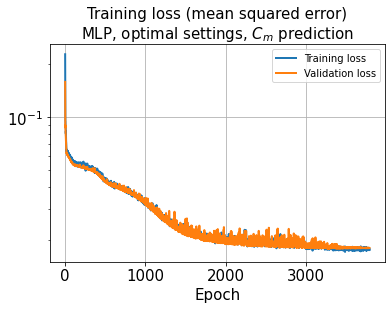

In [31]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nMLP, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

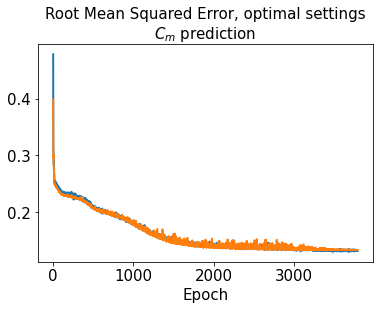

In [32]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

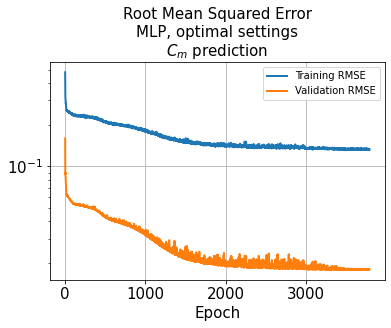

In [33]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nMLP, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [34]:
train_results = model.evaluate(x_train, y_train)

219/219 [==============================] - 1s 4ms/step - loss: 0.0179 - rmse: 0.1337


In [35]:
val_results = model.evaluate(x_val, y_val)

63/63 [==============================] - 0s 3ms/step - loss: 0.0178 - rmse: 0.1332


In [36]:
test_results = model.evaluate(x_test, y_test)

32/32 [==============================] - 0s 3ms/step - loss: 0.0176 - rmse: 0.1324


In [37]:
decoded_train_ = model.predict(x_train)
decoded_val_ = model.predict(x_val)
decoded_test_ = model.predict(x_test)

32/32 [==============================] - 0s 1ms/step


In [38]:
decoded_train_

array([[0.22177804],
       [0.89756143],
       [0.21974906],
       ...,
       [0.12934552],
       [0.2788188 ],
       [0.17468649]], dtype=float32)

In [39]:
def define_index(cm, y):
    return np.unique(np.where(np.isin(cm, y)))

In [40]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [41]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [42]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [43]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [44]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [45]:
model_directory = "D:\\TrainedModels\\20221227"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221227unsteadyValidation_MLP_01Flaps_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_layers) +"layers_"+str(n_units)+"units_randomState50CmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [46]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [47]:
os.chdir(storage_dir)

In [48]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real)*np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real+y_pred)

In [49]:
l2_error_train = l2_error(decoded_train, y_train)
mape_train = smape(decoded_train, y_train)
print(l2_error_train)
print(mape_train)

0.39707399659199966
23.350580237297198


In [50]:
l2_error_val = l2_error(decoded_val, y_val)
mape_val= smape(decoded_val, y_val)
print(l2_error_val)
print(mape_val)

0.40449770899986914
23.955615984573665


In [51]:
l2_error_test = l2_error(decoded_test, y_test)
mape_test= smape(decoded_test, y_test)
print(l2_error_test)
print(mape_test)

0.3981351263917322
23.90633455403783


In [52]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [53]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [54]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [55]:
mape_train_list = []
for i in range(0, len(x_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [56]:
mape_val_list = []
for i in range(0, len(x_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [57]:
mape_test_list = []
for i in range(0, len(x_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [58]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

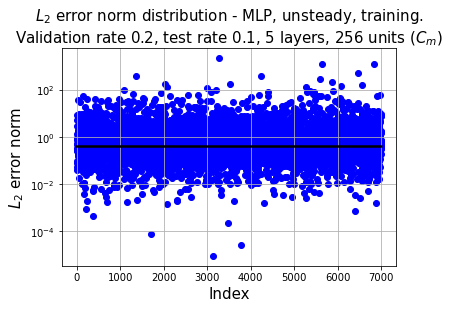

In [59]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

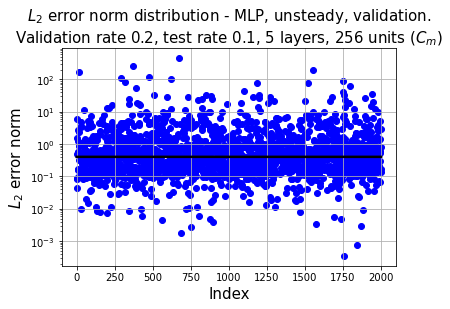

In [60]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

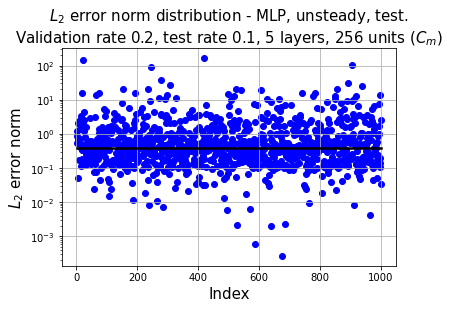

In [61]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [62]:
predicted = model.predict(x)

313/313 [==============================] - 1s 2ms/step


In [63]:
predicted.shape

(10000, 1)

In [64]:
l2_error(predicted, y)

0.3121987041534254

In [65]:
tTrain = x[index_train]+10
tVal = x[index_val]+10
tTest = x[index_test]+10

In [66]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [67]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [68]:
x += 10

In [69]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_0_Cm
        savename1 = "CmComparison_NACA0018.jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(x[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(x[:5000], denormalize(cm), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

L2 error of Cm: 0.3023


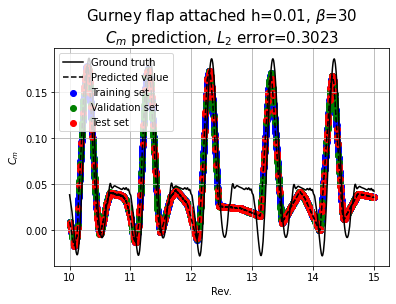

L2 error of Cm: 0.3214


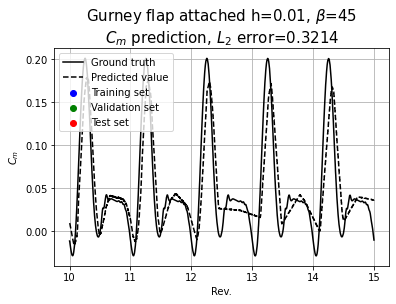

In [71]:
h = [0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03]
beta = [0, 30, 45, 30, 45, 30, 45, 90, 90, 90, 60, 60, 60, 75, 75, 75]
for i in range(1, 3):
    # Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
#     # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*(i-1):t_len*i,:]
    y_corres = y[t_len*(i-1):t_len*i,:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    else:
        print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
    
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

In [72]:
def Cm_trainTestSplit_Plot2(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_0_Cm
        savename1 = "CmComparison_NACA0018.jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm), 'b--', label='Predicted value')
#     plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#     plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#     plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

NACA0018 airfoil without Gurney flap
L2 error of Cm: 0.3023


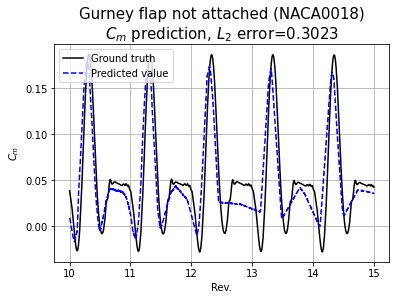

L2 error of Cm: 0.3214


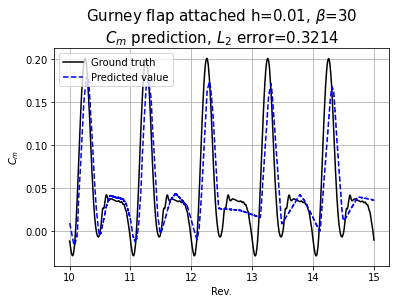

In [73]:
for i in range(0,2):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    else:
        print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

In [ ]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[1]) + r'$\beta$=%d'%(beta[1])+'\n$C_m$ prediction, training $L_2$ error=%.4f'%(l2_error_train)
title_Cm = title_n_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
# plt.scatter(tVal, iVal, color='g', label='Validation set')
# plt.scatter(tTest,iTest, color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [ ]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_0_Cm = 'Gurney flap attached h=%.2f, '%(h[1]) + r'$\beta$=%d'%(beta[1])+'\n$C_m$ prediction, validation $L_2$ error=%.4f'%(l2_error_val)
title_Cm = title_0_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
#plt.scatter(tTrain, iTrain, color='b', label='Training set')
plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#plt.scatter(tTest, iTest, color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [ ]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_0_Cm = 'Gurney flap attached h=%.2f, '%(h[1]) + r'$\beta$=%d'%(beta[1])+'\n$C_m$ prediction, test $L_2$ error=%.4f'%(l2_error_test)
title_Cm = title_0_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
#plt.scatter(tTrain, iTrain, color='b', label='Training set')
#plt.scatter(tVal, iVal, color='g', label='Validation set')
plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()